# Question 4: Miniproject
----
### Cell type classification

## 0. Setting

In [2]:
import os
import sys
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score



In [3]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [24]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'}
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

scores={}

## 1. Data Extraction

In [83]:
# Load data raw
main_dir = r'../'
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data')
fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: ../


### Cell properties

### PART0

In [84]:
data_df.head()

Cell_APThreshold_Slope Cell_Anatomy  Cell_Counter  Cell_Depth  Cell_ID  \
0                    10.0         L2/3           1.0       229.0  SC901_1   
1                    10.0         L2/3           1.0       229.0  SC901_1   
2                    10.0         L2/3           1.0       229.0  SC901_1   
3                    10.0         L2/3           1.0       229.0  SC901_1   
4                    10.0         L2/3           1.0       229.0  SC901_1   

  Cell_Layer Cell_TargetedBrainArea Cell_Type Cell_tdTomatoExpressing  \
0       L2/3                     C2       EXC                   False   
1       L2/3                     C2       EXC                   False   
2       L2/3                     C2       EXC                   False   
3       L2/3                     C2       EXC                   False   
4       L2/3                     C2       EXC                   False   

   Mouse_DateOfBirth  ... Sweep_Counter  \
0                NaN  ...           1.0   
1                NaN  ...           2.0   
2                NaN  ...           3.0   
3                NaN  ...           4.0   
4                NaN  ...           5.0   

                             Sweep_MembranePotential  \
0  [-0.044009375, -0.044028125, -0.0439875, -0.04...   
1  [-0.046275, -0.04629375, -0.046259375, -0.0462...   
2  [-0.041896875, -0.0419125, -0.041909375, -0.04...   
3  [-0.04655625, -0.0465875, -0.046575, -0.046596...   
4  [-0.047296875, -0.047284375, -0.047265625, -0....   

  Sweep_MembranePotential_SamplingRate  \
0                              20000.0   
1                              20000.0   
2                              20000.0   
3                              20000.0   
4                              20000.0   

                           Sweep_PassiveContactTimes  \
0  [[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...   
1  [[15.274999999999999, 15.375], [16.247, 16.643...   
2  [[4.347000000000001, 7.0390000000000015], [8.2...   
3                                                nan   
4  [[4.411000000000001, 4.4809999999999945], [5.2...   

                                    Sweep_QuietTimes Sweep_StartTime  \
0  [[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...          2005.0   
1  [[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...          2005.0   
2      [[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]          2005.0   
3  [[0.002, 2.764], [12.03, 14.464], [14.814, 15....          2005.0   
4  [[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...          2005.0   

        Sweep_Type                                 Sweep_WhiskerAngle  \
0     active touch  [2.740000000000009, 2.740000000000009, 2.74000...   
1     active touch  [2.680000000000007, 2.680000000000007, 2.68000...   
2  passive contact  [1.4958937492820894, 1.5019819900587095, 1.509...   
3     active touch  [2.467493802679826, 2.459711310964792, 2.46562...   
4     active touch  [2.4399999999999977, 2.4399999999999977, 2.440...   

  Sweep_WhiskerAngle_SamplingRate  \
0                           100.0   
1                           100.0   
2                           100.0   
3                           100.0   
4                           100.0   

                                 Sweep_WhiskingTimes  
0                  [[6.118, 6.326], [7.942, 13.856]]  
1  [[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...  
2                    [[2.15, 3.652], [4.362, 5.848]]  
3  [[2.766, 12.026], [15.626, 18.406], [18.814, 1...  
4  [[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...  

[5 rows x 24 columns]

In [85]:
# Cell ID
# We do have several data for the same cell but we don't need to distinguish them
data_df['Cell_ID']

0      SC901_1
1      SC901_1
2      SC901_1
3      SC901_1
4      SC901_1
        ...   
826    AP068_1
827    AP068_1
828    AP068_1
829    AP068_1
830    AP068_1
Name: Cell_ID, Length: 831, dtype: object

In [86]:
# Cell_Counter WTF??
data_df['Cell_Counter']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
826    1.0
827    1.0
828    1.0
829    1.0
830    1.0
Name: Cell_Counter, Length: 831, dtype: float64

In [87]:
# Cell_tdTomatoExpressing WTF??
data_df['Cell_tdTomatoExpressing'].value_counts()

Cell_tdTomatoExpressing
True     548
False    283
Name: count, dtype: int64

In [88]:
# Mouse Genotype WTF??
data_df['Mouse_Genotype'].value_counts()

Mouse_Genotype
Sst-Cre                              279
C57Bl6j                              199
PV-Cre                               184
VIP_IRES_Cre                          61
Scnn1a-Cre                            52
VIP-Cre                               35
B6(Cg)-Etv1<tm1.1(cre/ERT2)Zjh>/J     21
Name: count, dtype: int64

In [89]:
# keep :
# Properties
part0 = data_df[['Cell_ID','Cell_Depth','Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type']]

In [90]:
# is cell anatomy the same as cell layer ? # TODO

In [91]:
# remove the nan in cell depth
mask = np.isnan(part0.Cell_Depth)
mask = [not m for m in mask]
part0 = part0[mask]

# remove the pb in cell targetedBrain area
part0 = part0[part0.Cell_TargetedBrainArea != 'C2?']

for col in ['Cell_Depth','Cell_Layer','Cell_TargetedBrainArea', 'Cell_Type'] :
    print(part0[col].unique())

print(len(part0))

[229. 350. 550. 244. 250. 212. 140. 650. 335. 225. 198. 516. 500. 200.
 150. 190. 300. 160. 320. 170. 330. 348. 305. 396. 223. 197. 360. 340.
 560. 665. 551. 571. 586. 601. 496. 523. 432. 440. 266. 381. 156. 256.
 354. 215. 213. 357. 314. 219. 288. 439. 410. 470. 403. 341. 582. 531.
 557. 533. 607. 630. 337. 327. 437. 333. 220. 616. 568. 451. 450. 452.
 480. 445. 490. 474. 399. 292. 263. 135. 124. 120. 141. 164. 231. 387.
 427. 429. 491. 467. 529. 462. 364. 538. 547. 497. 476. 528. 507. 521.
 514. 457. 424. 477. 473. 456. 461. 147. 154. 102. 123. 235. 227.  98.
 146. 125. 155. 207. 143. 100. 126. 149. 152.  97. 245. 184. 172. 174.
 240. 338. 368. 400. 234. 374. 443. 423. 463. 375. 222. 211. 233. 436.
 448. 425. 525. 469. 460. 430. 415. 444. 449. 269. 185. 264. 435. 570.
 169. 167. 199. 434. 465. 390. 455. 481. 421. 204. 180. 351. 391. 380.
 122. 175. 110. 113. 128. 130. 153. 157. 145. 158. 188. 196. 192. 232.
 205. 216. 176. 210. 178. 208. 194.]
['L2/3' 'L5' 'L4']
['C2' 'S1']
['EXC' 'P

In [92]:
for col in part0.columns[1:] :
    print(col, np.unique(part0[col].isna()))

Cell_Depth [False]
Cell_Layer [False]
Cell_TargetedBrainArea [False]
Cell_Type [False]


In [93]:
part0.rename(columns={'Cell_ID':'cell_id'}, inplace=True)
part0.rename(columns={'Cell_Type':'cell_type'}, inplace=True)

In [94]:
# Remove the duplicat
part0 = part0.drop_duplicates()
part0 = part0.reset_index()

In [95]:
len(part0)

237

### part1

In [96]:
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
all_cells = np.unique(data_df_subset.Cell_ID)

verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [],
          'ap_threshold': [],
          'ap_duration': [],
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(cell_list):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0

    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []

    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]

        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)


        # Else if no AP, subthreshold Vm is just Vm
        else:

            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)

        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)

        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]

        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary

    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]

    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft]

    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]

    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Cell 0/232
Cell 100/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
/tmp/ipykernel_2116/3249277681.py:136: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Cell 200/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Done!


In [97]:
part1 = pd.DataFrame(result_dict)
part1.head()

cell_id cell_type  firing_rate  ap_threshold  ap_duration   mean_vm  \
0  AP032_1       EXC     0.875000     -0.040795     0.608929 -0.064378   
1  AP032_2       EXC     1.857143     -0.040812     0.993269 -0.056189   
2  AP035_1       EXC     2.100000     -0.037562     0.786111 -0.058273   
3  AP035_2       EXC     0.900000     -0.031695     0.849537 -0.055222   
4  AP039_1       EXC     0.566667     -0.040215     0.866176 -0.060517   

     std_vm   fft_low  fft_high  
0  0.005948  0.000763  0.000070  
1  0.005208  0.000635  0.000090  
2  0.006374  0.000775  0.000053  
3  0.006061  0.000837  0.000069  
4  0.004220  0.000513  0.000054

In [98]:
# remove the cell type
part1 = part1.drop(columns = 'cell_type')

### part2

In [99]:
sweep_type = 'free whisking'

pre_window = 0.5 # time before whisking onset (s)
post_window = 0.5 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vmverbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[],
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [],
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }

# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0

    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []

    # Template
    tot_wp_events = []

    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []

    ## For that cell, iterate over trials
    for trial in trial_list:

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]

         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]


        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)

        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)!

        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue

        # Append each event-triggered vector and stack to an array
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)

        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)

        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)


    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events]

        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1)
        result_dict['wp_avg'] += [wp_avg] #add for that cell

        vm_avg = np.mean(tot_vm_array, 1)
        result_dict['vm_avg'] += [vm_avg]

        ap_avg = np.mean(tot_ap_array, 1)
        result_dict['ap_avg'] += [ap_avg]

        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]


        #for epoch in range(wp_bounds.shape[0]):
        for epoch in epoch_bounds.keys():

            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))

            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]

            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))

            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]


    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]

        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]

        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]

        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]

        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]


# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars

# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 100/232
Cell 200/232
Done!


In [100]:
# keep wp_amplitude_pre, wp_amplitude_post, vm_amplitude_pre, vm_amplitude_post, ap_fr_pre, ap_fr_post
part2 = result_df[['cell_id', 'cell_type', 'wp_amplitude_pre','wp_amplitude_post', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_fr_pre', 'ap_fr_post' ]]
part2.head()

cell_id cell_type  wp_amplitude_pre  wp_amplitude_post  vm_amplitude_pre  \
0  AP032_1        PV       -139.536777        -135.226516        -55.504155   
1  AP032_2        PV       -139.157622        -134.807553        -48.994021   
2  AP035_1        PV       -131.406960        -125.811327        -54.334653   
3  AP035_2        PV       -132.794568        -118.696745        -50.060496   
4  AP039_1       SST       -146.466663        -138.432118        -57.928339   

   vm_amplitude_post  ap_fr_pre  ap_fr_post  
0         -55.399560  23.241104   27.065590  
1         -50.584425  30.007502    8.752188  
2         -59.056842  24.381095    7.501875  
3         -53.241710  39.176461   19.588230  
4         -62.284089   0.000000    0.000000

In [101]:
# Add to the columns the label for the exp
part2.columns += '_FW'
part2.rename(columns={'cell_id_FW':'cell_id'}, inplace=True)

/tmp/ipykernel_2116/3503326707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part2.rename(columns={'cell_id_FW':'cell_id'}, inplace=True)


In [102]:
part2 = part2.drop(columns = 'cell_type_FW')

### Part3

In [103]:
sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm


data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
all_cells = np.unique(data_df_subset.Cell_ID)

verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[],
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [],
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }

# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0

    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []

    # Template
    tot_wp_events = []

    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []

    ## For that cell, iterate over trials
    for trial in trial_list:

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get event times for that trial
        event_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        if np.isnan(event_times).all(): #if no active touch events, just skip
            continue

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]

         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]


        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)


        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)!

        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)



        #if type(wp_event) == int:
        #    continue
        #if type(vm_event) == int:
        #    continue
        #if type(ap_event) == int:
        #    continue

        # Append each event-triggered vector and stack to an array
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)

        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)

        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)


    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events]

        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1)
        result_dict['wp_avg'] += [wp_avg] #add for that cell

        vm_avg = np.mean(tot_vm_array, 1)
        result_dict['vm_avg'] += [vm_avg]

        ap_avg = np.mean(tot_ap_array, 1)
        result_dict['ap_avg'] += [ap_avg]

        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]

        #for epoch in range(wp_bounds.shape[0]):
        for epoch in epoch_bounds.keys():

            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))

            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]

            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))

            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]


    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]

        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]

        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]

        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]


# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars

# For array-based data, on must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/134


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 100/134


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


KeyboardInterrupt: 

In [ ]:
part3 = result_df[['cell_id', 'cell_type', 'wp_amplitude_pre','wp_amplitude_post', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_fr_pre', 'ap_fr_post' ]]
part3.head()

cell_id cell_type  wp_amplitude_pre  wp_amplitude_post  vm_amplitude_pre  \
0  JP902_1       EXC          1.313173           4.325349        -57.048425   
1  JP903_1       EXC          6.090980          11.033949        -68.167575   
2  JP905_1       EXC          7.643778          10.227399        -55.262389   
3  JP906_1       EXC         -4.364575          -0.040696        -55.650343   
4  JP907_1       EXC         -5.679912          -1.912861        -53.102919   

   vm_amplitude_post  ap_fr_pre  ap_fr_post  
0         -58.194868   0.000000    0.000000  
1         -66.258805   0.800801    0.000000  
2         -54.555092   1.540002    0.769616  
3         -48.444484   0.588824    4.708236  
4         -53.095735   0.000000    0.000000

In [ ]:
# Add a column for the exp label
part3.columns += '_AT'
part3.rename(columns={'cell_id_AT':'cell_id'}, inplace=True)

/tmp/ipykernel_127353/1554253047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part3.rename(columns={'cell_id_AT':'cell_id'}, inplace=True)


In [ ]:
part3 = part3.drop(columns = 'cell_type_AT')

### MERGING

In [ ]:
merged = pd.merge(part0, part1,  on='cell_id', how='outer')
merged = merged.drop(columns ='index')

merged = pd.merge(merged, part2,  on='cell_id', how='outer')

merged = pd.merge(merged, part3, on='cell_id', how='outer')
merged.head()

cell_id  Cell_Depth Cell_Layer Cell_TargetedBrainArea cell_type  \
0  AP032_1       158.0       L2/3                     C2        PV   
1  AP032_2         NaN        NaN                    NaN       NaN   
2  AP035_1       188.0       L2/3                     C2        PV   
3  AP035_2       196.0       L2/3                     C2        PV   
4  AP039_1       160.0       L2/3                     C2       SST   

   firing_rate  ap_threshold  ap_duration   mean_vm    std_vm  ...  \
0     0.875000     -0.040795     0.608929 -0.064378  0.005948  ...   
1     1.857143     -0.040812     0.993269 -0.056189  0.005208  ...   
2     2.100000     -0.037562     0.786111 -0.058273  0.006374  ...   
3     0.900000     -0.031695     0.849537 -0.055222  0.006061  ...   
4     0.566667     -0.040215     0.866176 -0.060517  0.004220  ...   

   vm_amplitude_pre_FW  vm_amplitude_post_FW  ap_fr_pre_FW  ap_fr_post_FW  \
0           -55.504155            -55.399560     23.241104      27.065590   
1           -48.994021            -50.584425     30.007502       8.752188   
2           -54.334653            -59.056842     24.381095       7.501875   
3           -50.060496            -53.241710     39.176461      19.588230   
4           -57.928339            -62.284089      0.000000       0.000000   

   wp_amplitude_pre_AT  wp_amplitude_post_AT  vm_amplitude_pre_AT  \
0                  NaN                   NaN                  NaN   
1                  NaN                   NaN                  NaN   
2                  NaN                   NaN                  NaN   
3                  NaN                   NaN                  NaN   
4                  NaN                   NaN                  NaN   

   vm_amplitude_post_AT  ap_fr_pre_AT  ap_fr_post_AT  
0                   NaN           NaN            NaN  
1                   NaN           NaN            NaN  
2                   NaN           NaN            NaN  
3                   NaN           NaN            NaN  
4                   NaN           NaN            NaN  

[5 rows x 24 columns]

In [ ]:
len(merged)

240

In [ ]:
# The merge works
# check if we have nan cell id
print(merged['cell_id'].isna().unique())

# check if we have twice the same cell
for index, values in zip(merged['cell_id'].value_counts().index, merged['cell_id'].value_counts().values):
    if values !=1 :
        print(merged[merged['cell_id']== index])

[False]


In [ ]:
# Replace missing values by the mean of the cell type
col_to_check = []
for col in merged.columns :
    if len(np.unique(merged[col].isna())) == 2 :
        col_to_check.append(col)

# Fill the missing value by the mean of the same cell type
for col in  col_to_check :
    nanvalues_type = merged['cell_type'][merged.isna()[col]]
    print(col)

    for id, type_cell in zip(nanvalues_type.index, nanvalues_type.values) :
        value_mean = merged[merged['cell_type'] == type_cell][col].mean()
        merged.at[id, col] = value_mean

Cell_Depth
Cell_Layer
Cell_TargetedBrainArea
cell_type
firing_rate
ap_threshold
ap_duration
mean_vm
std_vm
fft_low
fft_high
wp_amplitude_pre_FW
wp_amplitude_post_FW
vm_amplitude_pre_FW
vm_amplitude_post_FW
ap_fr_pre_FW
ap_fr_post_FW
wp_amplitude_pre_AT
wp_amplitude_post_AT
vm_amplitude_pre_AT
vm_amplitude_post_AT
ap_fr_pre_AT
ap_fr_post_AT


In [ ]:
# only 3 values we can remove them because we cannot replace them
for col in ['Cell_Depth', 'Cell_Layer', 'Cell_TargetedBrainArea', 'cell_type'] :
    id = merged[merged[col].isna()].index
    merged = merged.drop(id)


In [ ]:
# sanity check :
for col in merged.columns[1:] :
    print(np.unique(merged[col].isna()))

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


In [ ]:
# path to save
path = os.path.join(f'{main_dir}Data/data.csv')
merged.to_csv(path)

## 2. Exploration

In [5]:
main_dir='../'
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

#data
data = pd.read_csv(f'{main_dir}Data/data.csv')

In [6]:
data = data.drop(columns = 'Unnamed: 0')
data.head()

cell_id  Cell_Depth Cell_Layer Cell_TargetedBrainArea cell_type  \
0  AP032_1       158.0       L2/3                     C2        PV   
1  AP035_1       188.0       L2/3                     C2        PV   
2  AP035_2       196.0       L2/3                     C2        PV   
3  AP039_1       160.0       L2/3                     C2       SST   
4  AP039_2       176.0       L2/3                     C2       SST   

   firing_rate  ap_threshold  ap_duration   mean_vm    std_vm  ...  \
0     0.875000     -0.040795     0.608929 -0.064378  0.005948  ...   
1     2.100000     -0.037562     0.786111 -0.058273  0.006374  ...   
2     0.900000     -0.031695     0.849537 -0.055222  0.006061  ...   
3     0.566667     -0.040215     0.866176 -0.060517  0.004220  ...   
4     1.274725     -0.039683     0.766810 -0.064438  0.005904  ...   

   vm_amplitude_pre_FW  vm_amplitude_post_FW  ap_fr_pre_FW  ap_fr_post_FW  \
0           -55.504155            -55.399560     23.241104      27.065590   
1           -54.334653            -59.056842     24.381095       7.501875   
2           -50.060496            -53.241710     39.176461      19.588230   
3           -57.928339            -62.284089      0.000000       0.000000   
4           -49.709697            -54.663019      5.001250       1.154135   

   wp_amplitude_pre_AT  wp_amplitude_post_AT  vm_amplitude_pre_AT  \
0           193.537640            199.918717           -50.443263   
1           193.537640            199.918717           -50.443263   
2           193.537640            199.918717           -50.443263   
3           191.997949            199.756400           -52.285500   
4           191.997949            199.756400           -52.285500   

   vm_amplitude_post_AT  ap_fr_pre_AT  ap_fr_post_AT  
0            -47.847680     34.457937      78.611121  
1            -47.847680     34.457937      78.611121  
2            -47.847680     34.457937      78.611121  
3            -51.649055      8.013646      18.354518  
4            -51.649055      8.013646      18.354518  

[5 rows x 24 columns]

#### Corelation between features

In [6]:
# all correlation
sns.pairplot(data, hue='cell_type', palette=class_color)

Error in callback <function flush_figures at 0x7f0beb799800> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

#### Correlation between the two studies AT , FW  

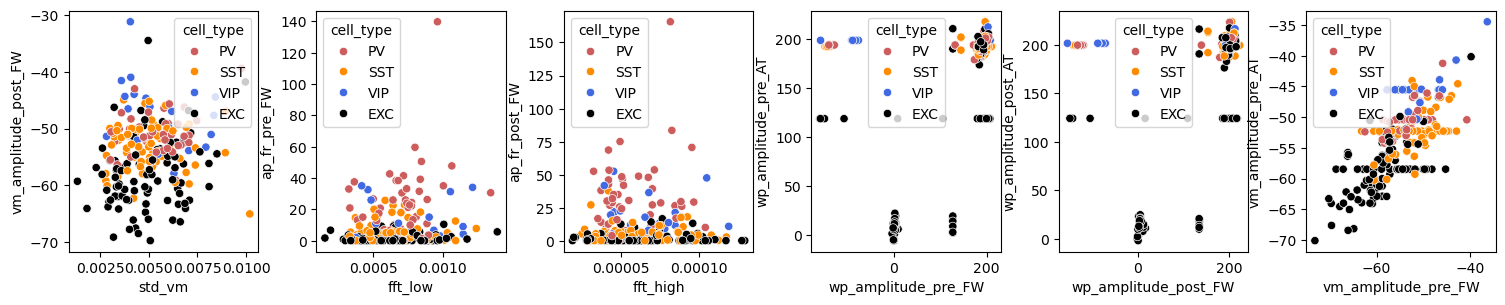

In [7]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
fig.tight_layout()
for i in range(6) :
    sns.scatterplot(x =data.iloc[:,9+i],  y=data.iloc[:,15+i], hue = data['cell_type'], ax= ax[i], palette=class_color)
    ax[i].set_xlabel(data.columns[9+i])
    ax[i].set_ylabel(data.columns[15+i])


#### boxplot to assess the variability

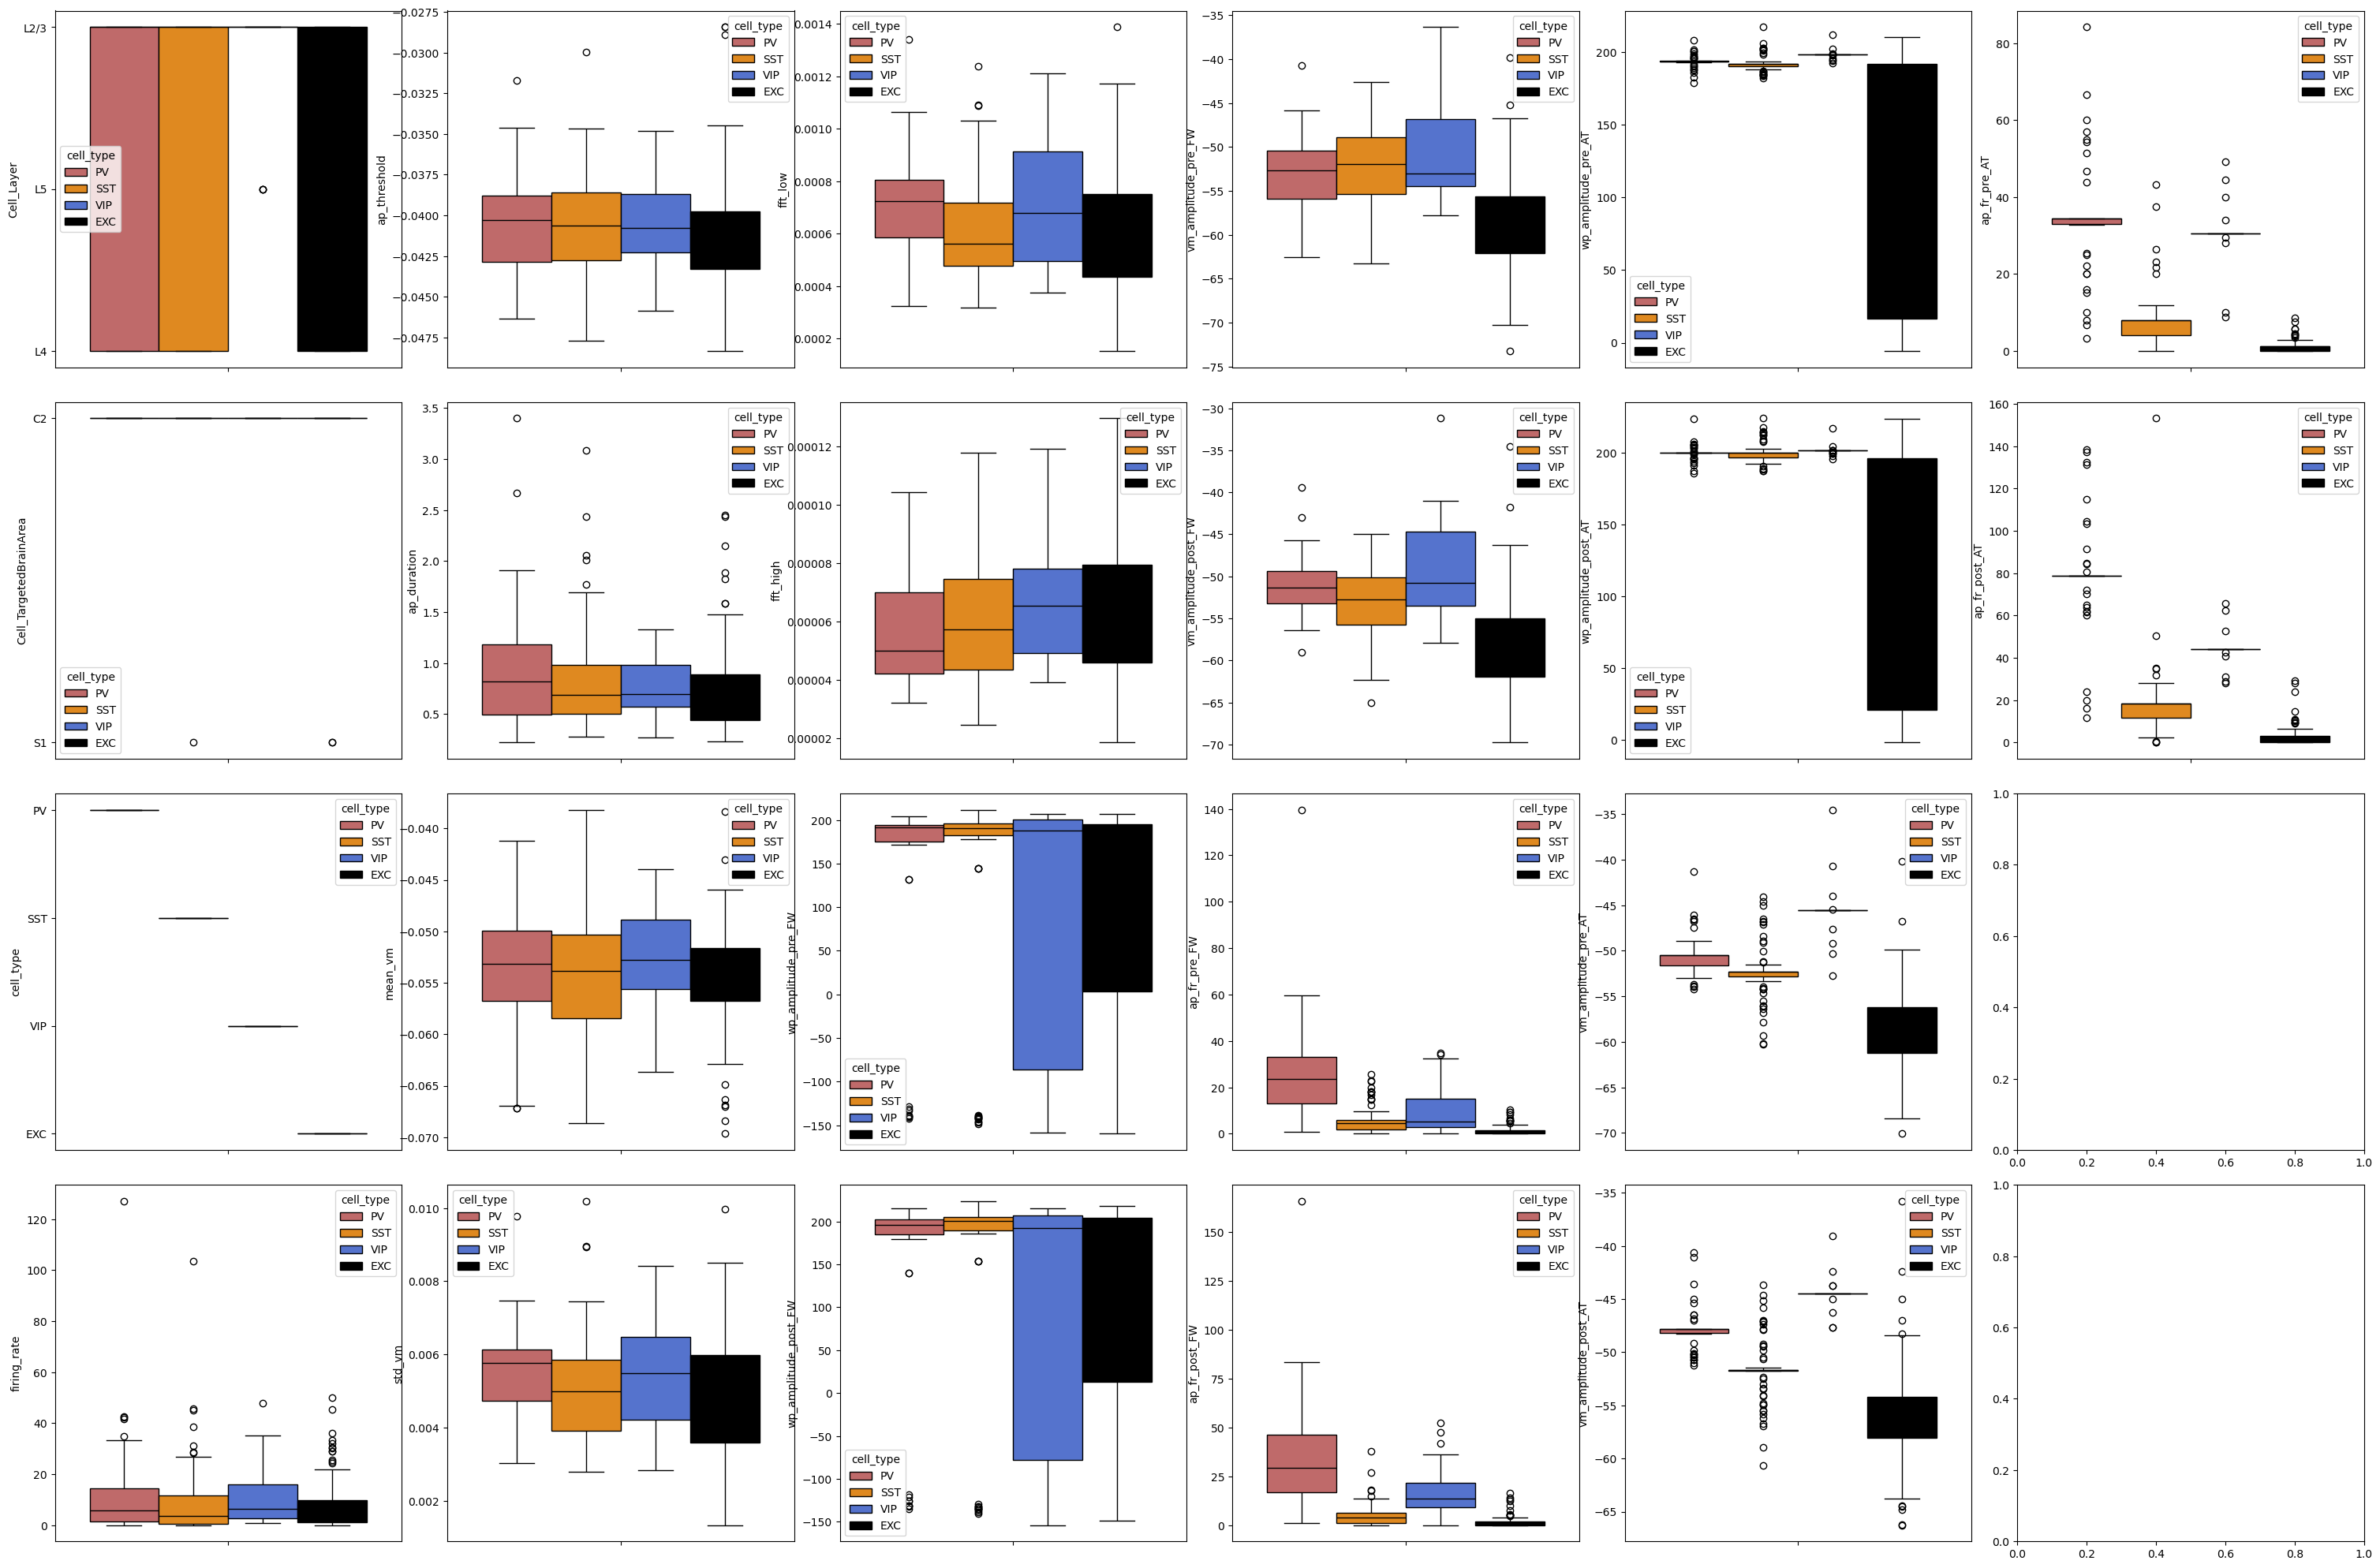

In [8]:
fig, axs= plt.subplots(4, 6, figsize = (30, 20))
fig.tight_layout()

col_to_plot = list(data.columns[2:]).copy()

for i, col in enumerate(col_to_plot):

    sns.boxplot(data,y= col, ax=axs[int(i%4)][int(i/4)], hue = 'cell_type', palette=class_color)

#### Class balance

<Axes: xlabel='cell_type', ylabel='Count'>

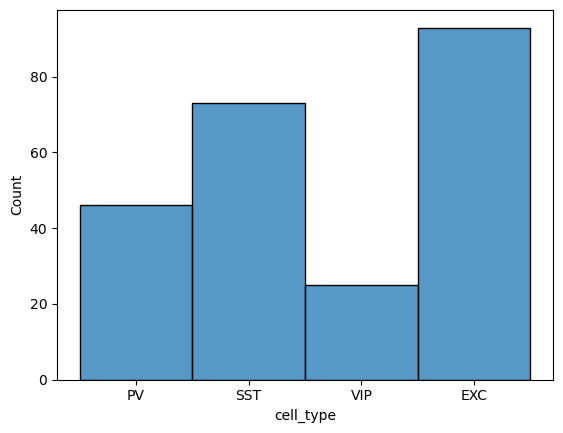

In [9]:
sns.histplot(data['cell_type'])

## 3. Formate Data

In [7]:
######## Class label ###########
y = data.cell_type

# Numerical encoding

label_map = {'EXC':0,'PV' : 10, 'VIP' : 11, 'SST' :12} # you can change the label as you prefer here
y_all = y.map(label_map)

######## Feature matrix ###########
X = data.copy()
X = X.drop(columns = ['cell_type', 'cell_id']) # drop the labels, drop the cell_id (we don't want them)

# Numerical encoding
X = pd.get_dummies(X) * 1

In [8]:
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.base import clone
from collections import Counter
from sklearn.preprocessing import StandardScaler

x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(StandardScaler().fit_transform(X.to_numpy()), y_all.to_numpy(), test_size=0.2, stratify=y_all)
y_train_bin=np.where(y_train_all==0,0,1)
y_test_bin=np.where(y_test_all==0,0,1)

inhib_id_train=np.argwhere(y_train_all!=0).ravel()
inhib_id_test=np.argwhere(y_test_all!=0).ravel()

x_train_inhib=x_train_all[inhib_id_train]
x_test_inhib=x_test_all[inhib_id_test]


y_train_inhib=y_train_all[inhib_id_train]
y_test_inhib=y_test_all[inhib_id_test]

In [9]:
#classification weights
def weightsdet(y_train):
       # 1. Calculate the class frequencies (counts of each class)
       class_counts = Counter(y_train)
       total_samples = len(y_train)
       # 2. Calculate class weights based on the inverse of the class frequencies
       return {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

weights_bin=weightsdet(y_train_bin)
print(weights_bin)
weights_inhib=weightsdet(y_train_inhib)
print(weights_inhib)

{1: 0.8217391304347826, 0: 1.277027027027027}
{12: 0.6609195402298851, 10: 1.0360360360360361, 11: 1.9166666666666667}


# 4. Baseline model 


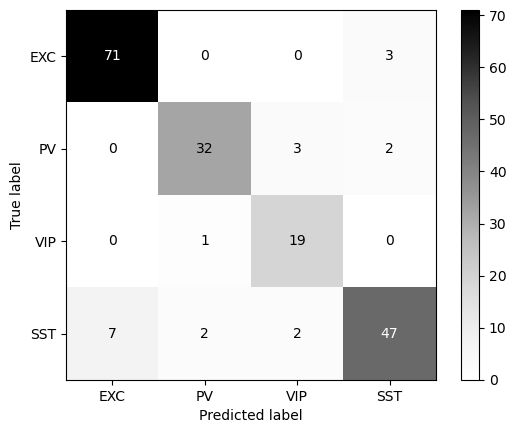

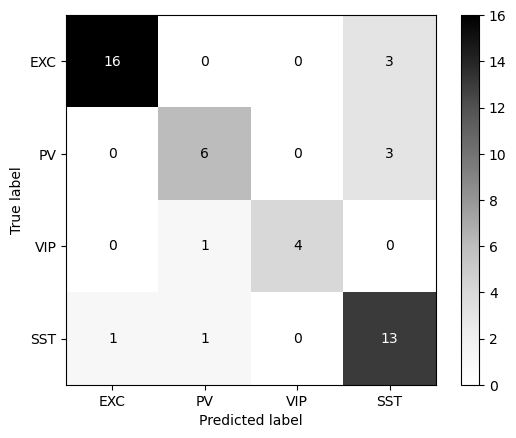

In [25]:
# Train 1 KNN to learn the 4 class above 
knn_base = KNeighborsClassifier(n_neighbors=4)

# Grid search parameter
param_grid_knn = {
    'n_neighbors': [4],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn_base, param_grid_knn, cv=5, scoring='accuracy')
grid_search.fit(x_train_all,y_train_all)
knn_params=grid_search.best_params_

knn_base = KNeighborsClassifier(**knn_params)

# Prediction
knn_base.fit(x_train_all, y_train_all)
y_pred_train = knn_base.predict(x_train_all)
y_pred_test= knn_base.predict(x_test_all)

# Confusion Metrics
ConfusionMatrixDisplay(confusion_matrix(y_train_all,y_pred_train),  display_labels=cell_class_order).plot(cmap=plt.cm.Greys)
f1_train = f1_score(y_train_all,y_pred_train, average='micro')
scores['Baseline train'] = f1_train

ConfusionMatrixDisplay(confusion_matrix(y_test_all,y_pred_test),  display_labels=cell_class_order).plot(cmap=plt.cm.Greys)
f1_test = f1_score(y_test_all,y_pred_test, average='micro')
scores['Baseline test'] = f1_test


## 4. PCA

In [26]:
def pca(x,y, component_vis=None, X_columns=X.columns, threshold=1):
    pca=PCA()
    x_pca=pca.fit_transform(x)
    print(pca.explained_variance_ratio_)
    # Plot the Scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
    plt.grid(True)
    plt.show()

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(cumulative_variance)
    plt.bar(x=range(1,len(cumulative_variance )+1),height=np.round(cumulative_variance* 100,decimals=1))
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Components')
    plt.title('Cumulative variance')
    plt.show()
    # Find the number of components needed to reach 98% explained variance

    num_components = np.argmax(cumulative_variance >= 1-1e-9) + 1
    print(f"Number of components to retain {threshold*100}% variance: {num_components}")
    vis_comp= num_components if component_vis==None else component_vis
    if np.size(vis_comp)==1:
        x_vis=x_pca[:, :vis_comp]
        pca_columns = [f'PC{i+1}' for i in range(vis_comp)]
    else:
        x_vis=x_pca[:, np.array(vis_comp)+1]
        pca_columns = [f'PC{i}' for i in vis_comp]
    # Create a DataFrame for the reduced PCA data

    X_pca_df = pd.DataFrame(x_vis, columns=pca_columns)

    display(X_pca_df)
    # Add the labels to the DataFrame
    X_pca_df['Label'] = y # Ensure 'y' is aligned with the data and categorical if needed


    # Pair plot
    if len(np.unique(y)) == 2 : palette = {0:'k', 1:'r'}
    if len(np.unique(y)) == 3 : palette = {10: 'indianred', 11: 'royalblue', 12: 'darkorange'}
    if len(np.unique(y)) == 4 : palette = {0: 'k', 10: 'indianred', 11: 'royalblue', 12: 'darkorange'}

    sns.set(style="ticks")
    pairplot = sns.pairplot(X_pca_df, hue='Label', diag_kind='hist',palette=palette, markers=['o', 's'])

    plt.show()
    pca_loadings = pca.components_[:num_components]  # Loadings for the retained components
    pca_loadings_df = pd.DataFrame(
        pca_loadings.T,  # Transpose to align features with components
        columns=[f'PC{i+1}' for i in range(num_components)],
        index=X_columns  # Use feature names as the index
    )

    low_contribution_threshold = 0.1
    low_contributing_features = pca_loadings_df[(pca_loadings_df.abs() < low_contribution_threshold).all(axis=1)]

    print("Low-contributing features:")
    print(low_contributing_features.index.tolist())

    plt.figure(figsize=(30, 10))
    sns.heatmap(pca_loadings_df, annot=True, cmap='coolwarm', cbar=True)
    plt.title("PCA Loadings (Feature Contributions)")
    plt.xlabel("Principal Components")
    plt.ylabel("Original Features")
    plt.show()

    return x_pca[:, :num_components],[X.columns.get_loc(feature) for feature in low_contributing_features.index.tolist() if feature in X.columns], pca




[2.37172520e-01 1.47636421e-01 1.16207724e-01 7.74235371e-02
 7.60422711e-02 6.63084779e-02 5.90747255e-02 4.34847717e-02
 4.12291389e-02 3.23921415e-02 2.50571371e-02 2.14044332e-02
 1.51635580e-02 1.07712051e-02 9.38666814e-03 6.20445197e-03
 5.20680342e-03 4.71264847e-03 1.95318921e-03 1.66706076e-03
 1.44811080e-03 3.02860315e-05 2.27185080e-05 1.39451040e-33
 1.06750296e-33]


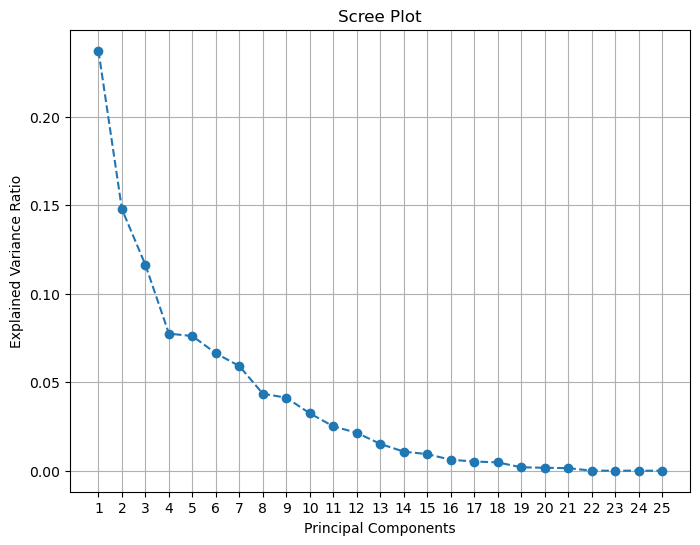

[0.23717252 0.38480894 0.50101667 0.5784402  0.65448247 0.72079095
 0.77986568 0.82335045 0.86457959 0.89697173 0.92202887 0.9434333
 0.95859686 0.96936806 0.97875473 0.98495918 0.99016599 0.99487863
 0.99683182 0.99849888 0.999947   0.99997728 1.         1.
 1.        ]


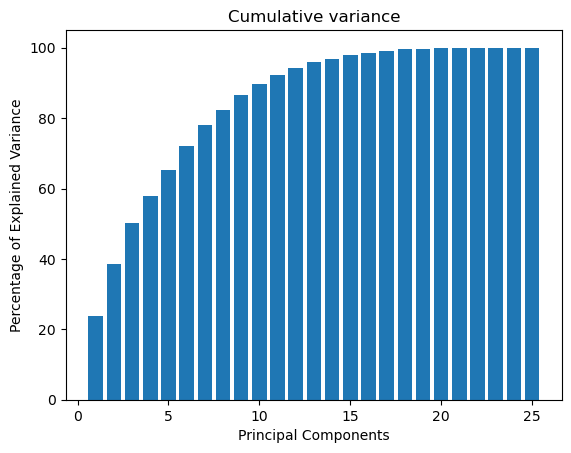

Number of components to retain 100% variance: 23


PC1       PC2
0   -0.339462 -1.242465
1    4.532390 -0.792935
2   -0.635731 -2.039736
3   -0.112626 -1.744575
4   -0.304578 -2.541232
..        ...       ...
184 -2.345758  2.473736
185 -2.128715  2.307137
186  3.314805 -0.455409
187 -1.773188 -1.336405
188  1.150042 -3.214884

[189 rows x 2 columns]

/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


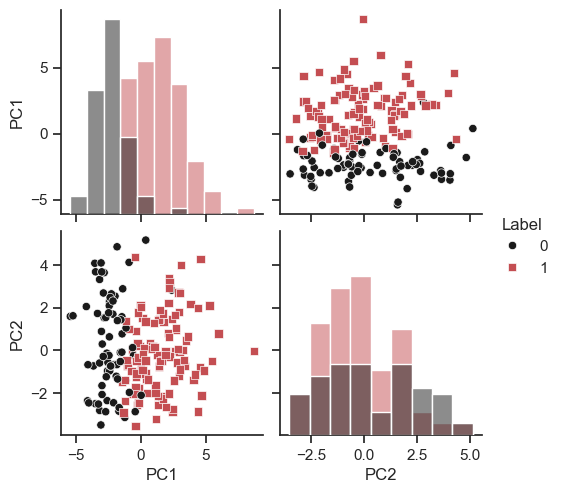

Low-contributing features:
[]


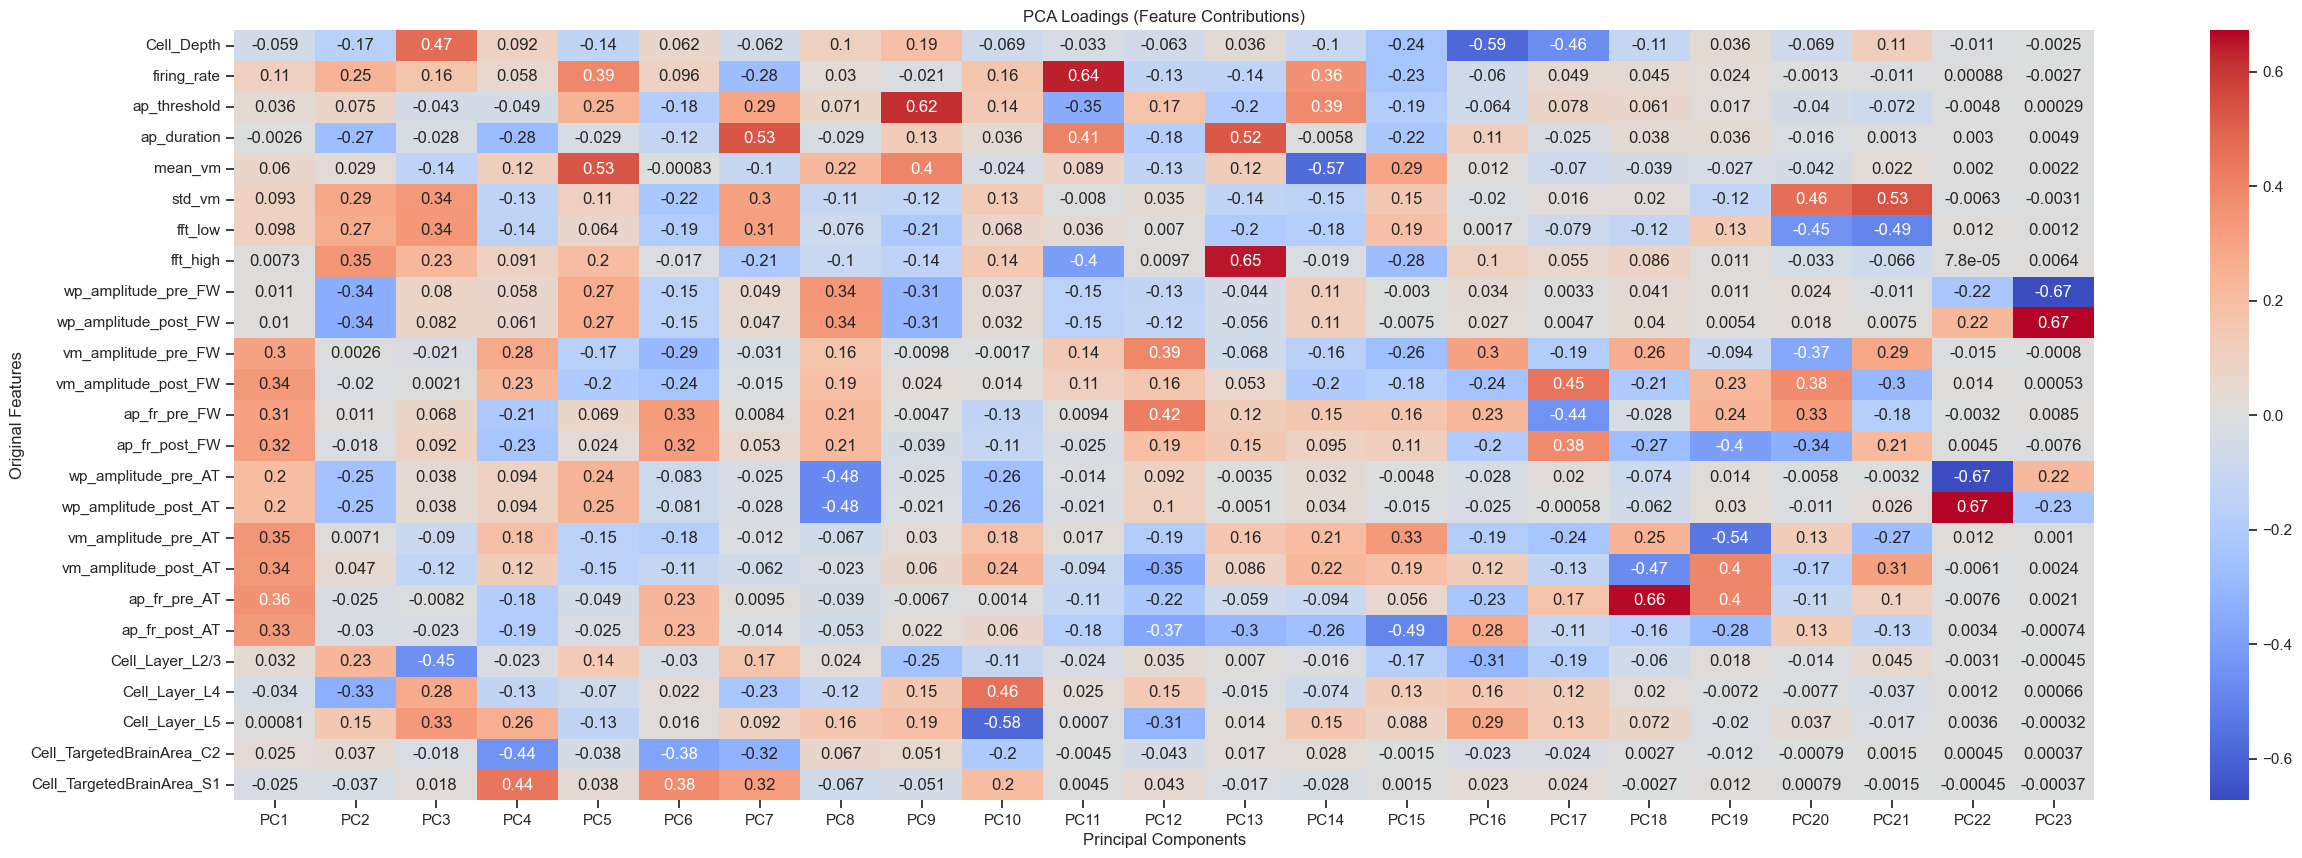

In [27]:
x_pca_bin, low_feat_bin, pca_all=pca(x_train_all,y_train_bin, component_vis=2,threshold=1)
x_test_pca_bin=pca_all.transform(x_test_all)[:,:x_pca_bin.shape[1]]

[2.14084932e-01 1.61455687e-01 1.26712210e-01 9.38792719e-02
 8.08626626e-02 6.69540083e-02 5.92033544e-02 4.00423703e-02
 3.50722508e-02 3.19157036e-02 2.27244710e-02 1.88658473e-02
 1.19397823e-02 1.07891734e-02 8.24777645e-03 6.98532637e-03
 4.96656750e-03 1.96691810e-03 1.65030699e-03 1.05647740e-03
 5.74597734e-04 2.87964996e-05 2.15075371e-05 1.25905340e-33
 2.65065127e-34]


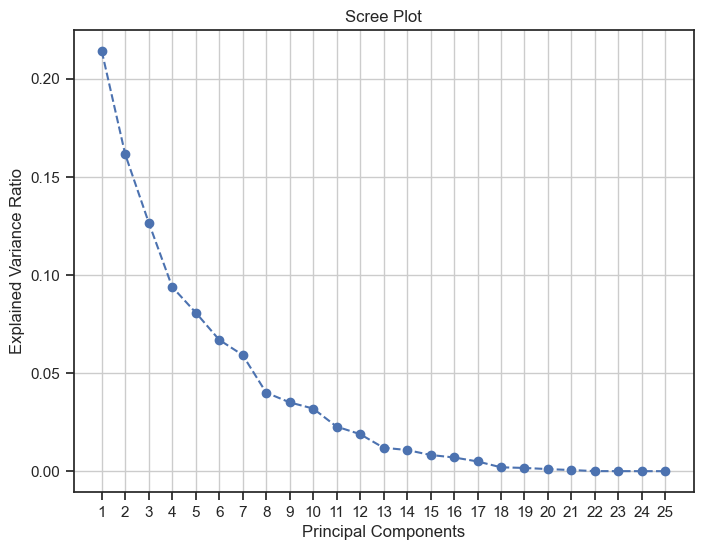

[0.21408493 0.37554062 0.50225283 0.5961321  0.67699476 0.74394877
 0.80315213 0.8431945  0.87826675 0.91018245 0.93290692 0.95177277
 0.96371255 0.97450173 0.9827495  0.98973483 0.9947014  0.99666831
 0.99831862 0.9993751  0.9999497  0.99997849 1.         1.
 1.        ]


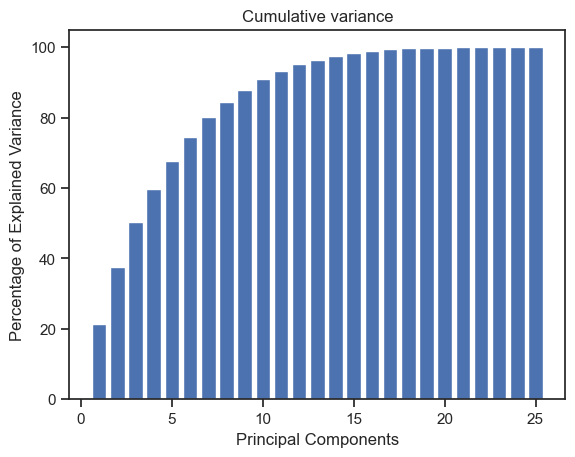

Number of components to retain 100% variance: 23


PC1      PC13
0   -0.826046  0.883049
1   -2.774649 -0.324109
2    0.566809 -0.031443
3    0.761420 -0.284921
4    0.293178  0.023336
..        ...       ...
110 -2.260957 -0.154071
111 -1.581548  0.494786
112 -0.857666  0.033442
113 -1.704627 -0.934260
114 -1.095821  0.191141

[115 rows x 2 columns]

/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


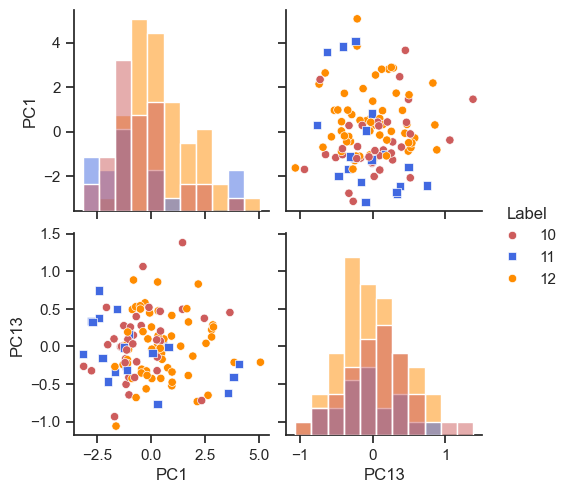

Low-contributing features:
[]


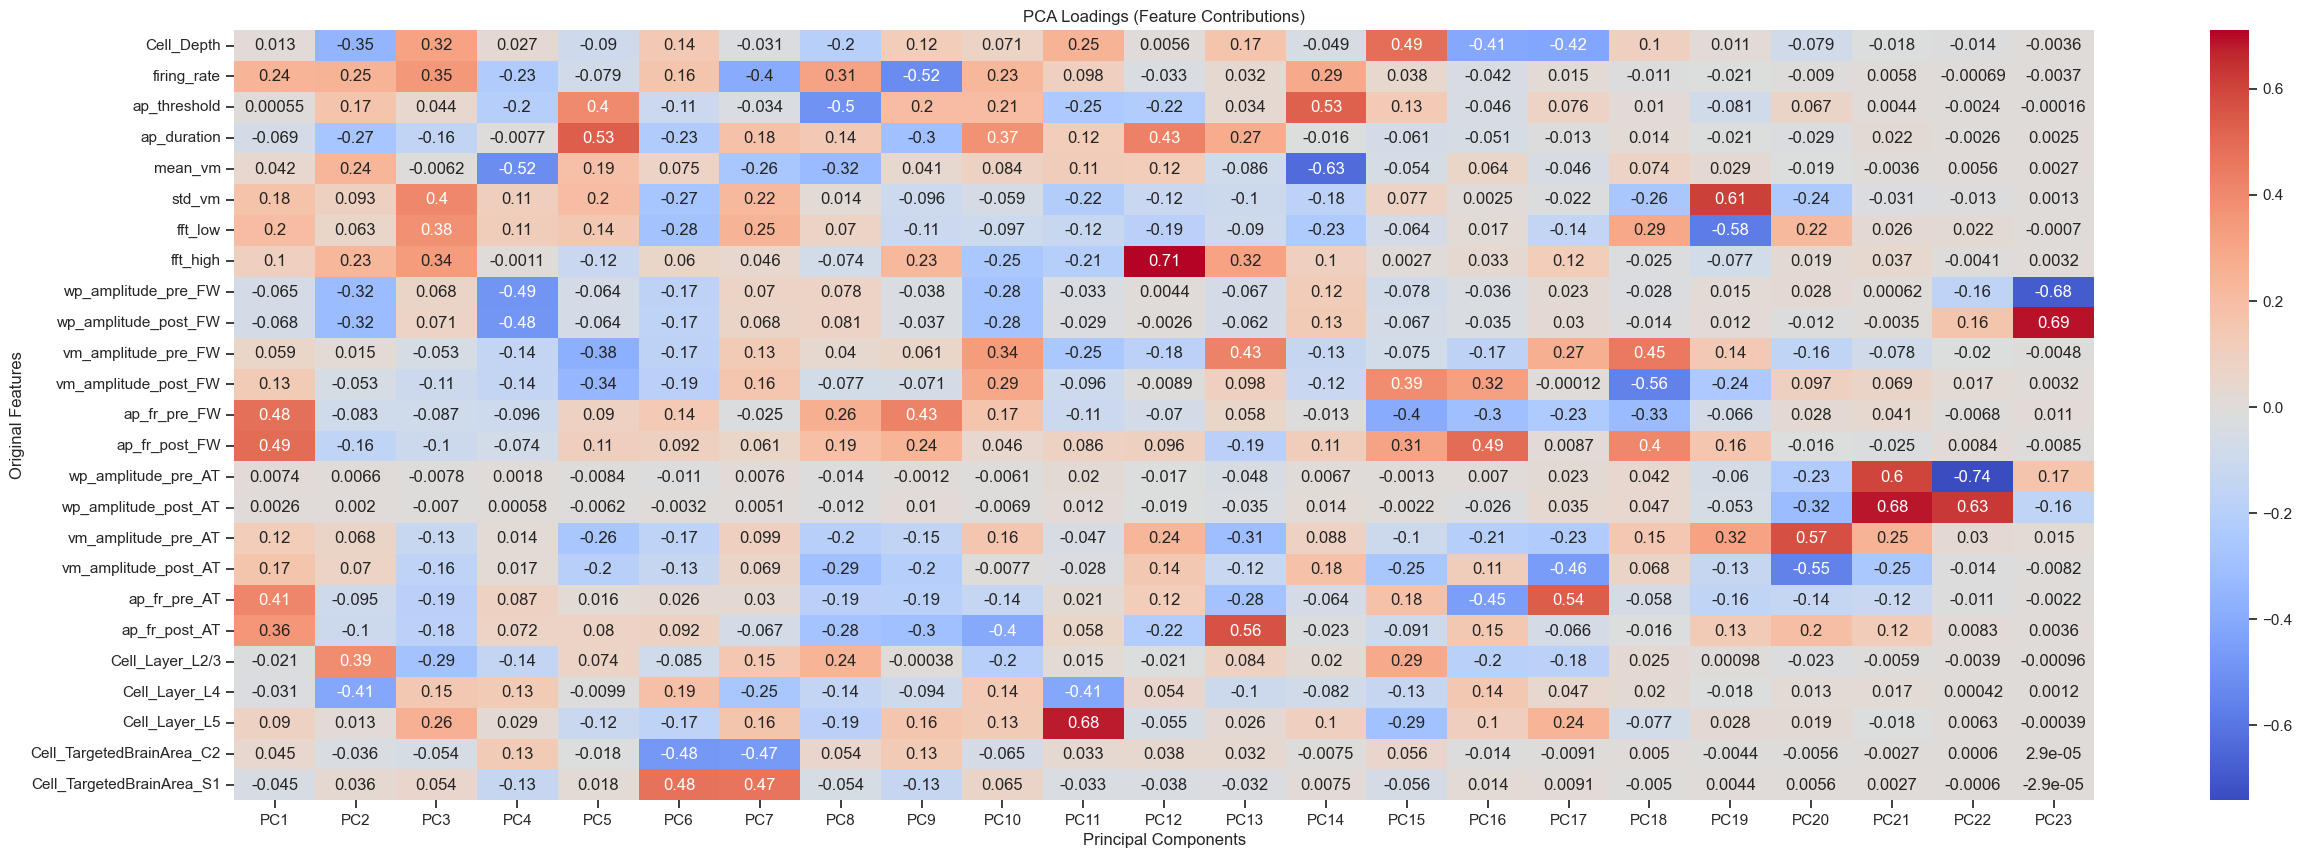

In [28]:
x_pca_inhib,  low_feat_inhib,_ =pca(x_train_inhib,y_train_inhib, component_vis=[1,13])

[2.14084932e-01 1.61455687e-01 1.26712210e-01 9.38792719e-02
 8.08626626e-02 6.69540083e-02 5.92033544e-02 4.00423703e-02
 3.50722508e-02 3.19157036e-02 2.27244710e-02 1.88658473e-02
 1.19397823e-02 1.07891734e-02 8.24777645e-03 6.98532637e-03
 4.96656750e-03 1.96691810e-03 1.65030699e-03 1.05647740e-03
 5.74597734e-04 2.87964996e-05 2.15075371e-05 8.19709432e-34
 3.63176171e-34]


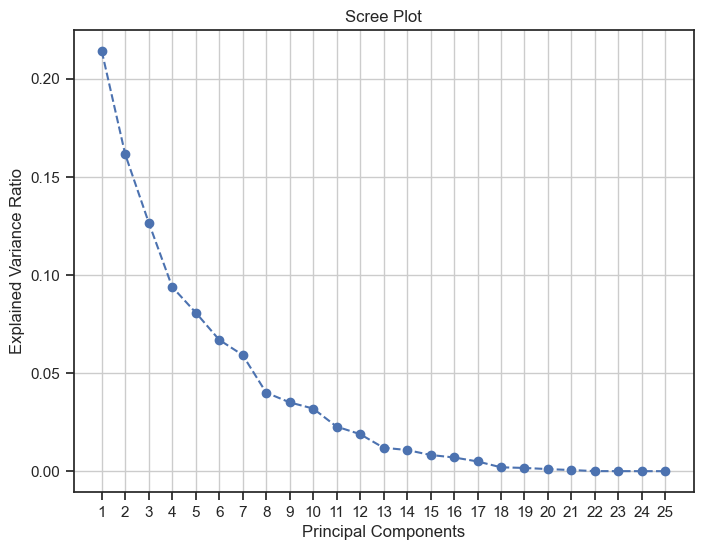

[0.21408493 0.37554062 0.50225283 0.5961321  0.67699476 0.74394877
 0.80315213 0.8431945  0.87826675 0.91018245 0.93290692 0.95177277
 0.96371255 0.97450173 0.9827495  0.98973483 0.9947014  0.99666831
 0.99831862 0.9993751  0.9999497  0.99997849 1.         1.
 1.        ]


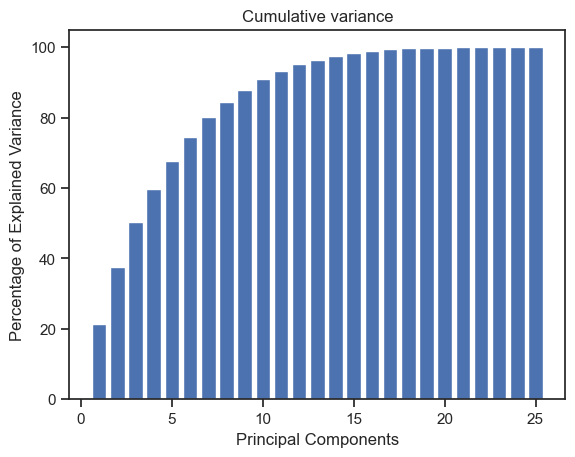

Number of components to retain 100% variance: 23


PC1       PC2
0   -2.485752  0.194096
1    1.902076 -0.227082
2   -2.186869 -1.975422
3   -1.797499 -1.500016
4   -2.161886 -2.605531
..        ...       ...
110  0.236783  0.208826
111  0.351469  2.337383
112  2.211565  2.615215
113  1.127163  0.290680
114 -0.787761 -3.063761

[115 rows x 2 columns]

/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/envs/bio482/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


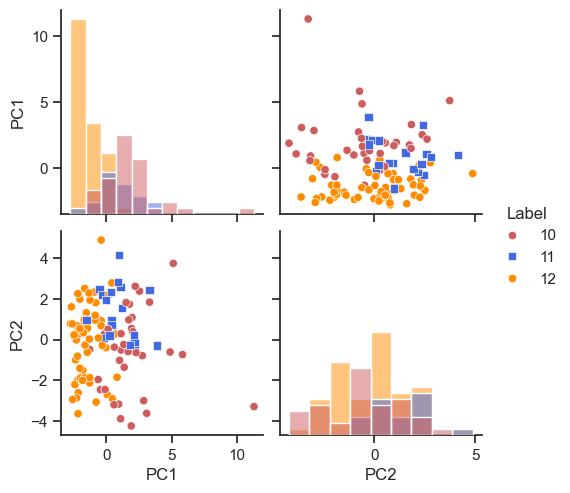

Low-contributing features:
[]


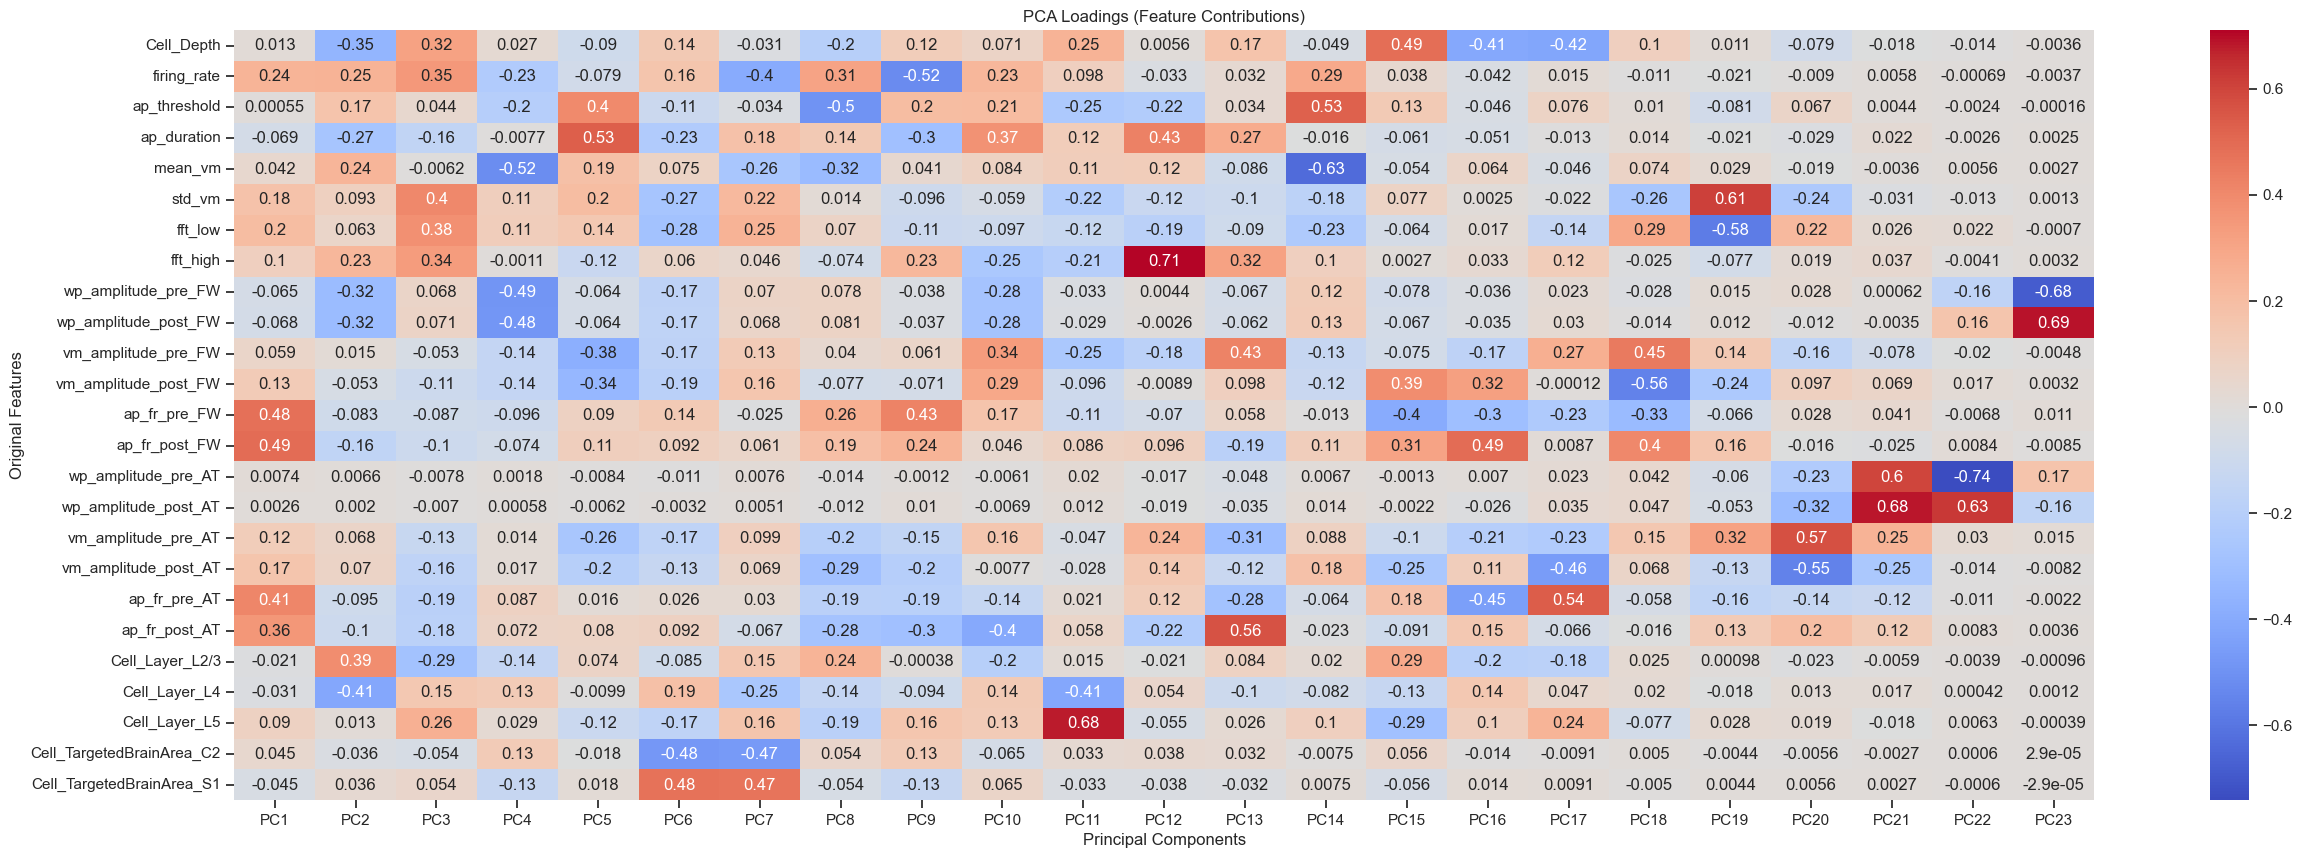

In [29]:
x_pca_inhib, _, pca_inhib=pca(np.delete(x_train_inhib, low_feat_inhib, axis=1),y_train_inhib, component_vis=2, X_columns=np.delete(X.columns, low_feat_inhib))
x_pca_inhib=pca_inhib.transform(np.delete(x_train_inhib, low_feat_inhib, axis=1))[:,:x_pca_inhib.shape[1]]
x_test_pca_inhib=pca_inhib.transform(np.delete(x_test_inhib, low_feat_inhib, axis=1))[:,:x_pca_inhib.shape[1]]

## 5. LDA

In [30]:
def lda(x,y, component_vis=False, X_columns=X.columns):
    lda=LDA()
    x_lda=lda.fit_transform(x,y)
    
    # plot 
    if component_vis == True :
        X_lda_df = pd.DataFrame(x_lda, columns=[f'C{i+1}' for i in range(x_lda.shape[1])])
        X_lda_df['Label'] = y 

        if len(np.unique(y)) == 2 : palette = {0:'k', 1:'r'}
        if len(np.unique(y)) == 3 : palette = {10: 'indianred', 11: 'royalblue', 12: 'darkorange'}
        if len(np.unique(y)) == 4 : palette = {0: 'k', 10: 'indianred', 11: 'royalblue', 12: 'darkorange'}
        

        sns.pairplot(X_lda_df, hue='Label', diag_kind='hist',palette=palette, markers=['o', 's'], corner=True)
        plt.show()
    return x_lda, lda



In [31]:
x_lda_bin, lda_bin=lda(x_train_all,y_train_bin, component_vis=False, X_columns=X.columns)
x_test_lda_bin = lda_bin.transform(x_test_all)

In [32]:
x_lda_inhib, lda_inhibitory =lda(x_train_inhib,y_train_inhib, component_vis=False, X_columns=X.columns)
x_test_lda_inhib = lda_inhibitory.transform(x_test_inhib)
x_test_lda_all=lda_inhibitory.transform(x_test_all)

## 6. Classification

### 6.1 hyperparameter selection

#### BINARY CLASSIFICATION

In [33]:

param_grid_svc = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'gamma': [0.0001, 0.001, 0.01, 0.1]  # Used for 'rbf' and 'poly'
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(x_train_all,y_train_bin)
svc_params=grid_search_svc.best_params_
print(svc_params, x_train_all.shape)

grid_search_svc.fit(x_pca_bin,y_train_bin)
svc_params_pca=grid_search_svc.best_params_
print(svc_params_pca, x_pca_bin.shape)

grid_search_svc.fit(x_lda_bin,y_train_bin)
svc_params_lda=grid_search_svc.best_params_
print(svc_params_lda, x_lda_bin.shape)

{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'} (189, 25)
{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'} (189, 23)
{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'} (189, 1)


In [34]:
print(cross_val_score(SVC(**svc_params),x_train_all,y_train_bin, cv=5).mean())
print(cross_val_score(SVC(**svc_params_pca),x_pca_bin,y_train_bin, cv=5).mean())
print(cross_val_score(SVC(**svc_params_lda),x_lda_bin,y_train_bin,cv=5).mean())

0.9522048364153628
0.9522048364153628
0.9524893314366999


In [35]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10, 20,30,40,50,100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

In [36]:
grid_search_knn.fit(x_train_all,y_train_bin)
knn_params=grid_search_knn.best_params_
print(knn_params, x_train_all.shape)
grid_search_knn.fit(x_pca_bin,y_train_bin)
knn_params_pca=grid_search_knn.best_params_
print(knn_params_pca, x_pca_bin.shape)
grid_search_knn.fit(x_lda_bin,y_train_bin)
knn_params_lda=grid_search_knn.best_params_
print(knn_params_lda, x_lda_bin.shape)

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'} (189, 25)
{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'} (189, 23)
{'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'uniform'} (189, 1)


In [37]:
print(cross_val_score(KNeighborsClassifier(**knn_params),x_train_all,y_train_bin, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_pca),x_pca_bin,y_train_bin, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_lda),x_lda_bin,y_train_bin, cv=5).mean())

0.9311522048364154
0.9206258890469418
0.9469416785206258


#### INHIBITORY CELL CLASSIFICATION

In [38]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10,20,30,],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(x_train_inhib,y_train_inhib)
knn_params_inhib=grid_search_knn.best_params_
print(knn_params_inhib, x_train_inhib.shape)
grid_search_knn.fit(x_pca_inhib,y_train_inhib)
knn_params_pca_inhib=grid_search_knn.best_params_
print(knn_params_pca_inhib, x_pca_inhib.shape)
grid_search_knn.fit(x_lda_inhib,y_train_inhib)
knn_params_lda_inhib=grid_search_knn.best_params_
print(knn_params_lda_inhib, x_lda_inhib.shape)

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'} (115, 25)
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'} (115, 23)
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'} (115, 2)


In [39]:
print(cross_val_score(KNeighborsClassifier(**knn_params_inhib),x_train_inhib,y_train_inhib, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_pca_inhib),x_pca_inhib,y_train_inhib, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_lda_inhib),x_lda_inhib,y_train_inhib, cv=5).mean())

0.8782608695652174
0.826086956521739
0.9652173913043478


### 6.2 Trainning

In [40]:
train_svc=SVC(**svc_params,class_weight=weights_bin, probability=True)
train_svc.fit(x_train_all,y_train_bin)

train_svc_pca=SVC(**svc_params_pca,class_weight=weights_bin,probability=True)
train_svc_pca.fit(x_pca_bin,y_train_bin)

train_svc_lda=SVC(**svc_params_lda,class_weight=weights_bin,probability=True)
train_svc_lda.fit(x_lda_bin,y_train_bin)


SVC(C=10, class_weight={0: 1.277027027027027, 1: 0.8217391304347826}, gamma=0.1,
    kernel='sigmoid', probability=True)

In [41]:
train_knn=KNeighborsClassifier(**knn_params)
train_knn.fit(x_train_all,y_train_bin)

train_knn_pca=KNeighborsClassifier(**knn_params_pca)
train_knn_pca.fit(x_pca_bin,y_train_bin)

train_knn_lda=KNeighborsClassifier(**knn_params_lda)
train_knn_lda.fit(x_lda_bin,y_train_bin)


KNeighborsClassifier(metric='euclidean', n_neighbors=50)

In [42]:
train_knn_inhib=KNeighborsClassifier(**knn_params_inhib)
train_knn_inhib.fit(x_train_inhib,y_train_inhib)

train_knn_pca_inhib=KNeighborsClassifier(**knn_params_pca_inhib)
train_knn_pca_inhib.fit(x_pca_inhib,y_train_inhib)

train_knn_lda_inhib=KNeighborsClassifier(**knn_params_lda_inhib)
train_knn_lda_inhib.fit(x_lda_inhib,y_train_inhib)


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### 6.4. Training scores 

1.0
1.0
0.960352422907489


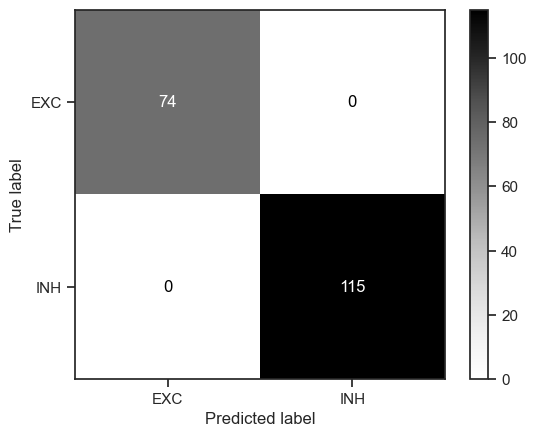

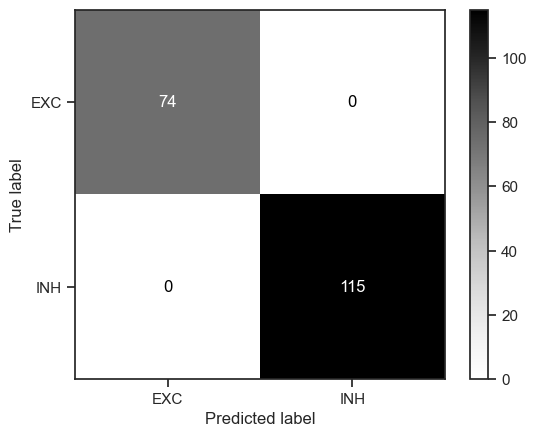

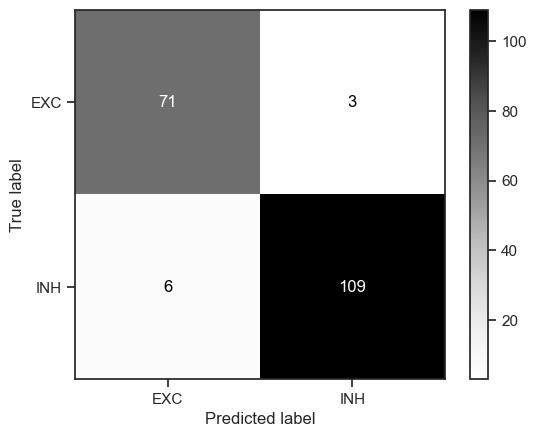

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc.predict(x_train_all)), display_labels=['EXC', 'INH']).plot( cmap=plt.cm.Greys)
f1 = f1_score(y_train_bin,train_svc.predict(x_train_all))
print(f1)
scores['train_svc'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc_pca.predict(x_pca_bin)),  display_labels=['EXC', 'INH']).plot(cmap=plt.cm.Greys)
f1 = f1_score(y_train_bin,train_svc_pca.predict(x_pca_bin))
print(f1)
scores['train_svc_pca'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc_lda.predict(x_lda_bin)),  display_labels=['EXC', 'INH']).plot( cmap=plt.cm.Greys)
f1=f1_score(y_train_bin,train_svc_lda.predict(x_lda_bin))
print(f1)
scores['train_svc_lda'] = f1

1.0
0.9487179487179487
0.9572649572649573


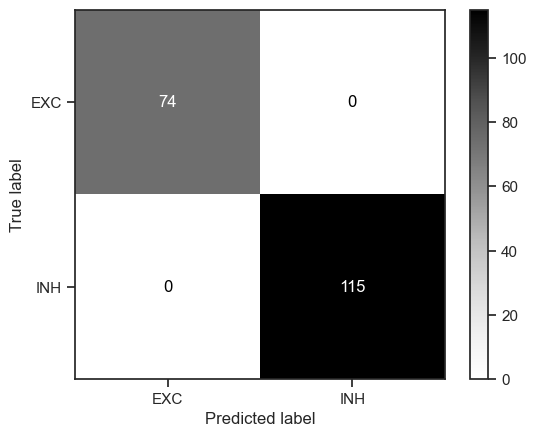

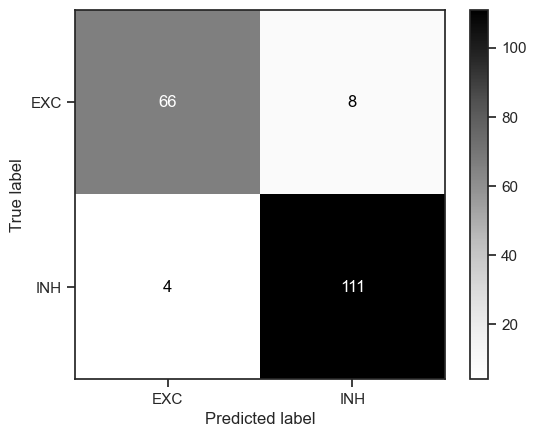

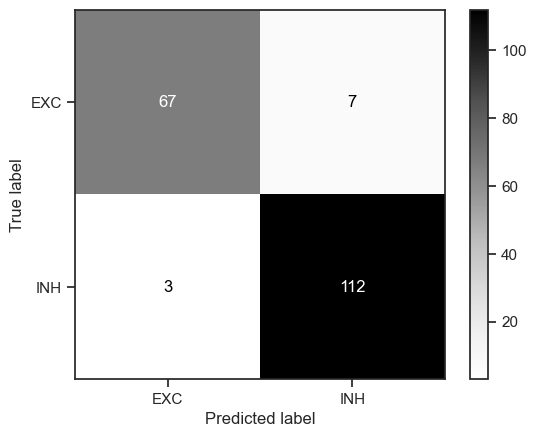

In [44]:
ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn.predict(x_train_all)), display_labels=['EXC', 'INH']).plot( cmap=plt.cm.Greys)
f1 = f1_score(y_train_bin,train_knn.predict(x_train_all))
print(f1)
scores['train_knn'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn_pca.predict(x_pca_bin)),  display_labels=['EXC', 'INH']).plot( cmap=plt.cm.Greys)
f1 = f1_score(y_train_bin,train_knn_pca.predict(x_pca_bin))
print(f1)
scores['train_knn_pca'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn_lda.predict(x_lda_bin)),  display_labels=['EXC', 'INH']).plot( cmap=plt.cm.Greys)
f1 = f1_score(y_train_bin,train_knn_lda.predict(x_lda_bin))
print(f1)
scores['train_knn_lda'] = f1


1.0
0.8434782608695653
0.9652173913043478


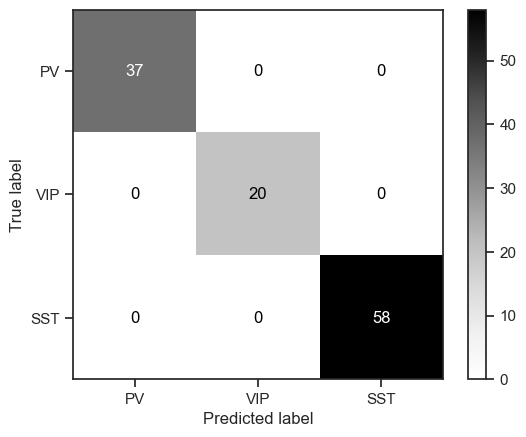

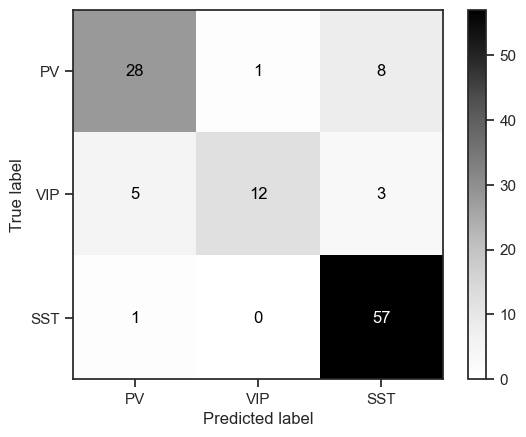

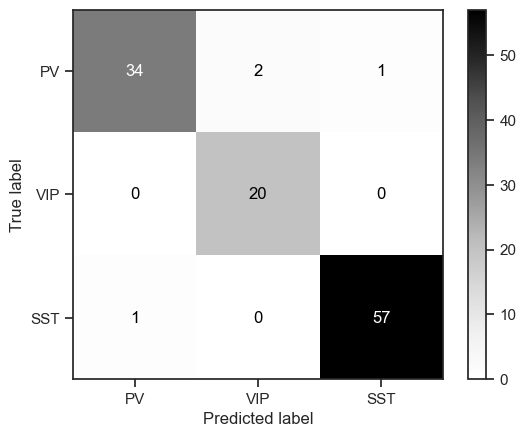

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_inhib.predict(x_train_inhib)), display_labels=cell_class_order[1:]).plot(cmap=plt.cm.Greys)
f1 = f1_score(y_train_inhib,train_knn_inhib.predict(x_train_inhib), average='micro')
print(f1)
scores['train_knn_inhib'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_pca_inhib.predict(x_pca_inhib)), display_labels=cell_class_order[1:]).plot(cmap=plt.cm.Greys)
f1 = f1_score(y_train_inhib,train_knn_pca_inhib.predict(x_pca_inhib),average='micro')
print(f1)
scores['train_knn_pca_inhib'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_lda_inhib.predict(x_lda_inhib)), display_labels=cell_class_order[1:]).plot(cmap=plt.cm.Greys)
f1 = f1_score(y_train_inhib,train_knn_lda_inhib.predict(x_lda_inhib),average='micro')
print(f1)
scores['train_knn_lda_inhib'] = f1


/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/2288944796.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


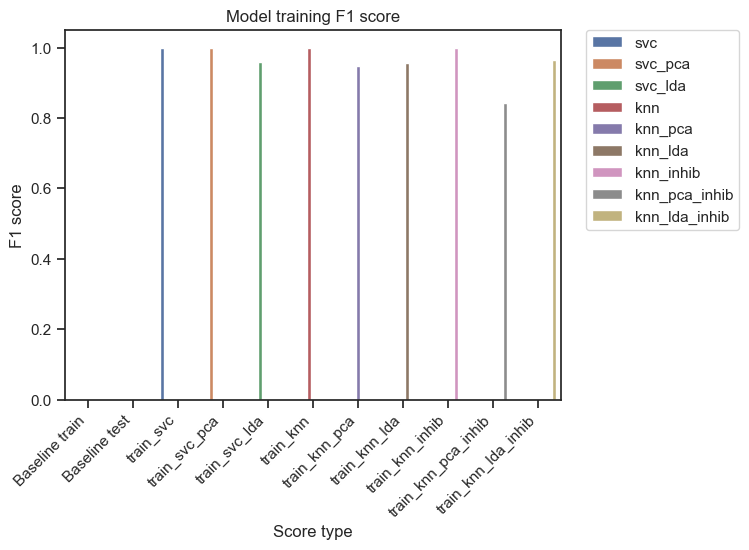

In [46]:
# Plot the Scores
df_scores = pd.DataFrame(columns = ['Score type','F1 score'])
for i,item in enumerate(scores.items()) : 
    df_scores.at[i,'Score type'] = item[0]
    df_scores.at[i,'F1 score'] = item[1]
    if item[0][:2] == 'tr' :
        df_scores.at[i,'Label'] = item[0][6:]
    if item[0][:2] == 'te' :
         df_scores.at[i,'Label'] = item[0][5:]

fig, ax = plt.subplots()
ax.set_title('Model training F1 score')
sns.barplot(data=df_scores, x='Score type', y='F1 score', hue='Label', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### TEST prediction

/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/2637415558.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


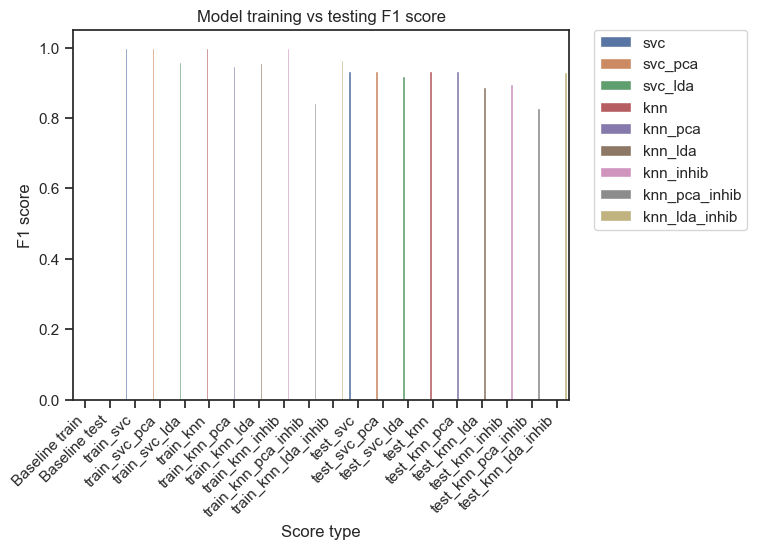

In [47]:
##### Binary classification - > 6 ≠ models #####
scores['test_svc'] = f1_score(y_test_bin,train_svc.predict(x_test_all))
scores['test_svc_pca'] = f1_score(y_test_bin,train_svc_pca.predict(x_test_pca_bin))
scores['test_svc_lda'] = f1_score(y_test_bin,train_svc_lda.predict(x_test_lda_bin))
scores['test_knn'] = f1_score(y_test_bin,train_knn.predict(x_test_all))
scores['test_knn_pca'] = f1_score(y_test_bin,train_knn_pca.predict(x_test_pca_bin))
scores['test_knn_lda'] = f1_score(y_test_bin,train_knn_lda.predict(x_test_lda_bin))

###### Inhibitory cells - > 3 different models ######
scores['test_knn_inhib'] = f1_score(y_test_inhib,train_knn_inhib.predict(x_test_inhib), average='micro')
scores['test_knn_pca_inhib'] = f1_score(y_test_inhib,train_knn_pca_inhib.predict(x_test_pca_inhib), average='micro')
scores['test_knn_lda_inhib'] = f1_score(y_test_inhib,train_knn_lda_inhib.predict(x_test_lda_inhib), average='micro')


# Plot the Scores
df_scores = pd.DataFrame(columns = ['Score type','F1 score'])
for i,item in enumerate(scores.items()) : 
    df_scores.at[i,'Score type'] = item[0]
    df_scores.at[i,'F1 score'] = item[1]
    if item[0][:2] == 'tr' :
        df_scores.at[i,'Label'] = item[0][6:]
    if item[0][:2] == 'te' :
         df_scores.at[i,'Label'] = item[0][5:]

fig, ax = plt.subplots()
ax.set_title('Model training vs testing F1 score')
sns.barplot(data=df_scores, x='Score type', y='F1 score', hue='Label', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


### Data vizualization

In [48]:
pca_2D=PCA(n_components=2)
x_pca_all=pca_2D.fit_transform(x_train_all)
x_pca_all_test=pca_2D.transform(x_test_all)
pca_raw=[x_pca_all,x_pca_all_test]
x_min_all, x_max_all = x_pca_all[:, 0].min() - 1, x_pca_all[:, 0].max() + 1
y_min_all, y_max_all = x_pca_all[:, 1].min() - 1, x_pca_all[:, 1].max() + 1
xx_all, yy_all = np.meshgrid(np.linspace(x_min_all, x_max_all, 100), np.linspace(y_min_all, y_max_all, 100))
x_pca_test=pca_2D.fit_transform(x_test_all)
x_min_test, x_max_test = x_pca_test[:, 0].min() - 1, x_pca_test[:, 0].max() + 1
y_min_test, y_max_test = x_pca_test[:, 1].min() - 1, x_pca_test[:, 1].max() + 1
xx_test, yy_test = np.meshgrid(np.linspace(x_min_test, x_max_test, 100), np.linspace(y_min_test, y_max_test, 100))
train_shape=xx_all.shape
test_shape=xx_test.shape

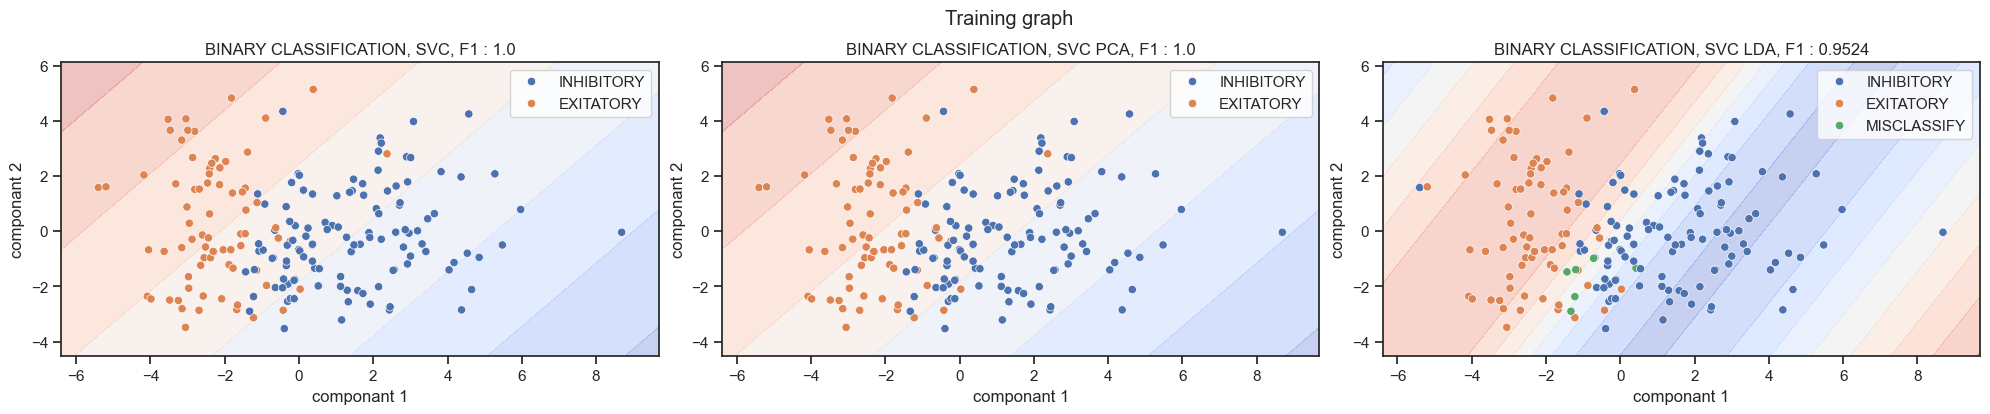

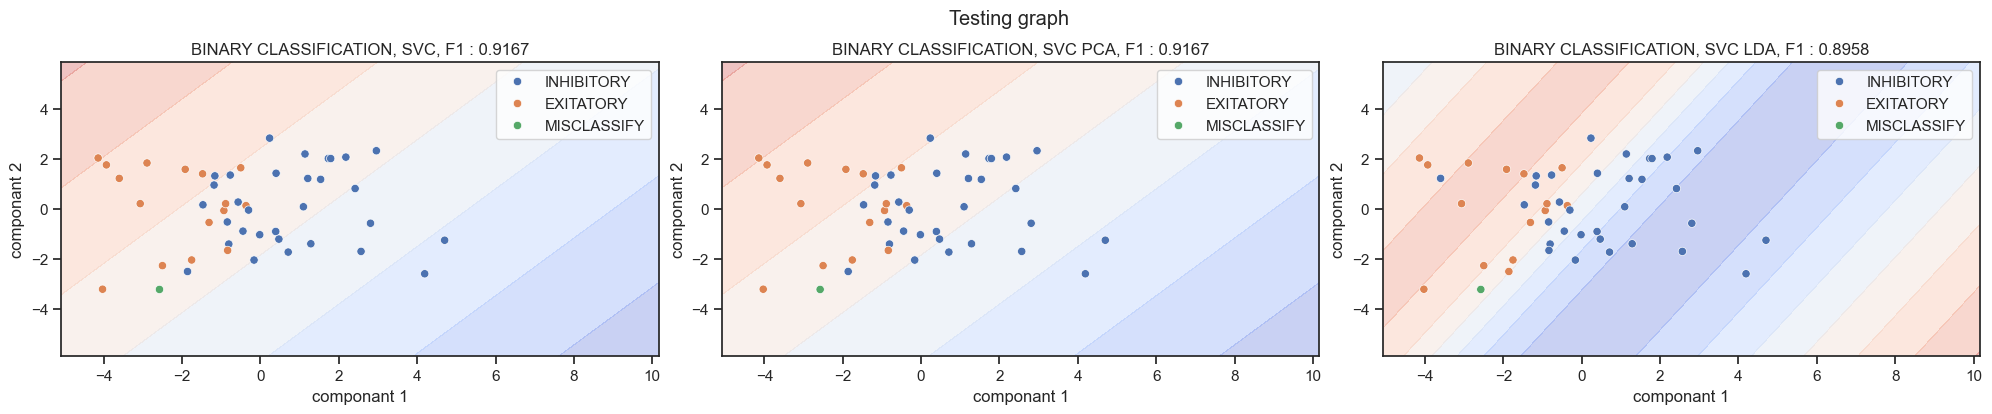

In [49]:
# STEP 1 : binary SVC

for j,mode in enumerate(['Train', 'Test'] ):
  fig, axs = plt.subplots(1, 3, figsize = (20, 4))
  fig.suptitle(f"{mode}ing graph")
  fig.tight_layout()

  models = [train_svc, train_svc_pca, train_svc_lda]
  models_name = ['SVC', 'SVC PCA', 'SVC LDA']

  if mode == 'Train':
    X1 = [x_train_all, x_pca_bin, x_lda_bin]
    y_true = y_train_bin
    xx,yy=xx_all, yy_all
   
    
  if mode == 'Test':
    X1 = [x_test_all , x_test_pca_bin, x_test_lda_bin]  
    y_true = y_test_bin
    xx,yy=xx_test, yy_test 
    
  inverse_pca_2D=pca_2D.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
  
  map_=[inverse_pca_2D,pca_all.transform(inverse_pca_2D)[:,:x_pca_bin.shape[1]], lda_bin.transform(inverse_pca_2D)]
 
  for i, model in enumerate(models) :
      # Misclassify
      Z = model.decision_function(map_[i])
      Z = Z.reshape(xx.shape)
      misclassified = [model.predict(X1[i]) != y_true]
      float_misclassified = [m *1 for m in misclassified]

      y_labels = y_true + float_misclassified
      y_maps = {0: 'EXITATORY', 1: 'INHIBITORY', 2: 'MISCLASSIFY'}
      y_labels_ =[y_maps[i] for i in y_labels[0]]

      df_result = pd.DataFrame(pca_raw[j])
      df_result['Labels'] = y_labels_

      final_score = f1_score(y_true,model.predict(X1[i]), average='micro')
      # Plot the decision boundary
      axs[i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
      sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i])
      axs[i].set_xlabel('componant 1')
      axs[i].set_ylabel('componant 2')
      axs[i].legend()

      axs[i].set_title(f"BINARY CLASSIFICATION, {models_name[i]}, F1 : {round(final_score, 4)}")

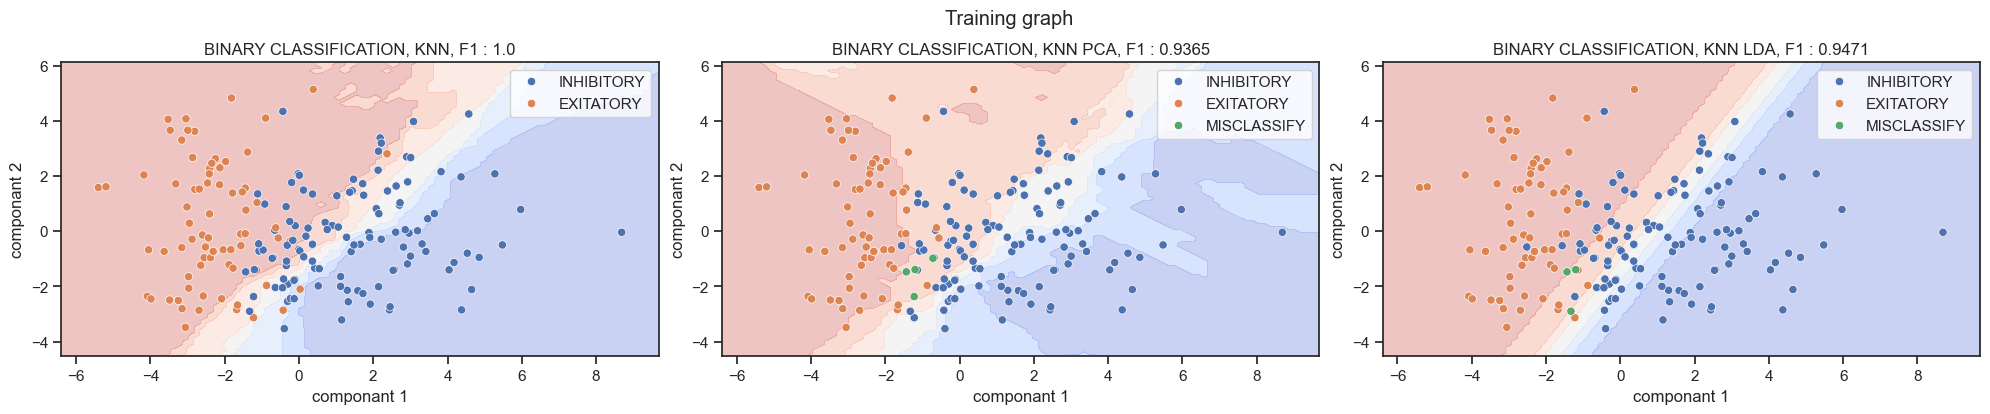

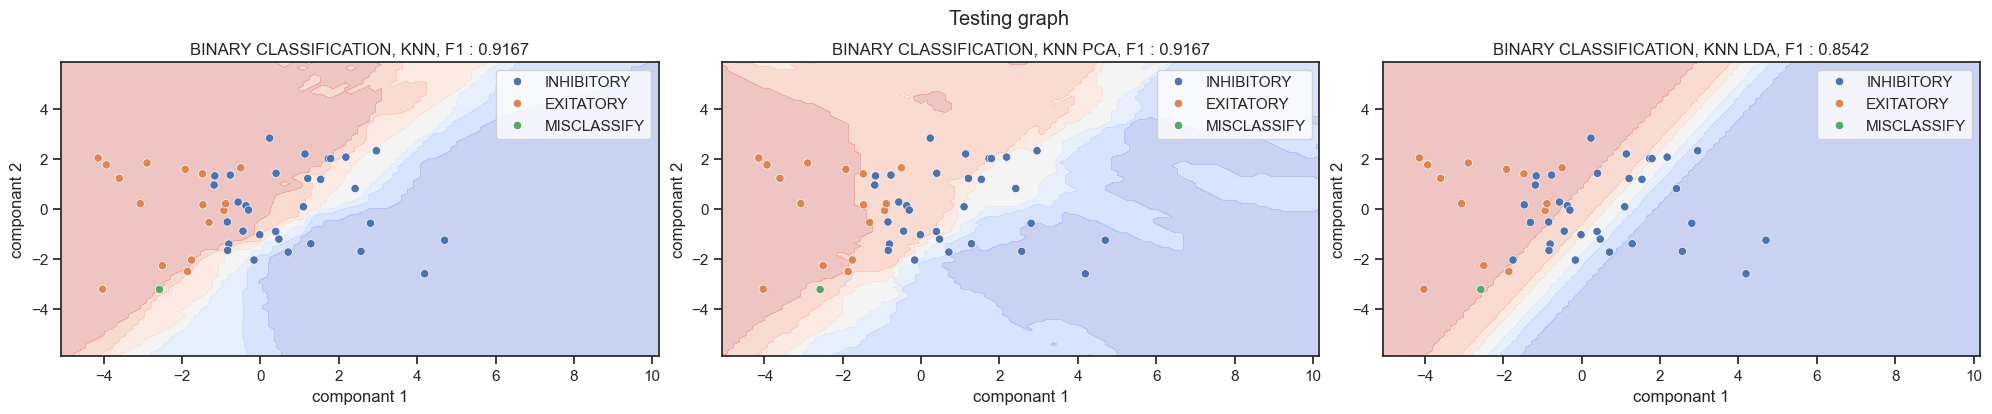

In [50]:
# STEP 1 : KNN
path = f'{main_dir}models/'

for k, mode in enumerate(['Train', 'Test']) :
  fig, axs = plt.subplots(1, 3, figsize = (20, 4))
  fig.suptitle(f"{mode}ing graph")
  
  fig.tight_layout()

  models = [train_knn, train_knn_pca, train_knn_lda]
  model_name = ['KNN', 'KNN PCA', 'KNN LDA']

  if mode == 'Train':
    X1 = [x_train_all, x_pca_bin, x_lda_bin]
    y_true = y_train_bin
    xx,yy=xx_all, yy_all
  if mode == 'Test':
    X1 = [x_test_all , x_test_pca_bin, x_test_lda_bin]  
    y_true = y_test_bin
    xx,yy=xx_test, yy_test 
  inverse_pca_2D=pca_2D.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
  
  map_=[inverse_pca_2D,pca_all.transform(inverse_pca_2D)[:,:x_pca_bin.shape[1]], lda_bin.transform(inverse_pca_2D)]

  for i, model in enumerate(models) :
      Z = model.predict_proba(map_[i])[:,1]
      Z = Z.reshape(xx.shape)
      # Misclassify
      misclassified = [model.predict(X1[i]) != y_true]
      float_misclassified = [m *1 for m in misclassified]
      
      y_labels = y_true + float_misclassified
      y_maps = {0: 'EXITATORY', 1: 'INHIBITORY', 2: 'MISCLASSIFY'}
      y_labels_ =[y_maps[i] for i in y_labels[0]]

      df_result = pd.DataFrame(pca_raw[k])
      df_result['Labels'] = y_labels_

      final_score = f1_score(y_true,model.predict(X1[i]), average='micro')
      axs[i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
      sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i])
      axs[i].set_xlabel('componant 1')
      axs[i].set_ylabel('componant 2')
      axs[i].legend()

      axs[i].set_title(f"BINARY CLASSIFICATION, {model_name[i]}, F1 : {round(final_score, 4)}")

In [52]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
def create_smooth_colormap(start_color, end_color, num_colors=256):
          """Create a smooth colormap transition between two colors."""
          cmap = mcolors.LinearSegmentedColormap.from_list("smooth_transition", [start_color, end_color], N=num_colors)
          return cmap

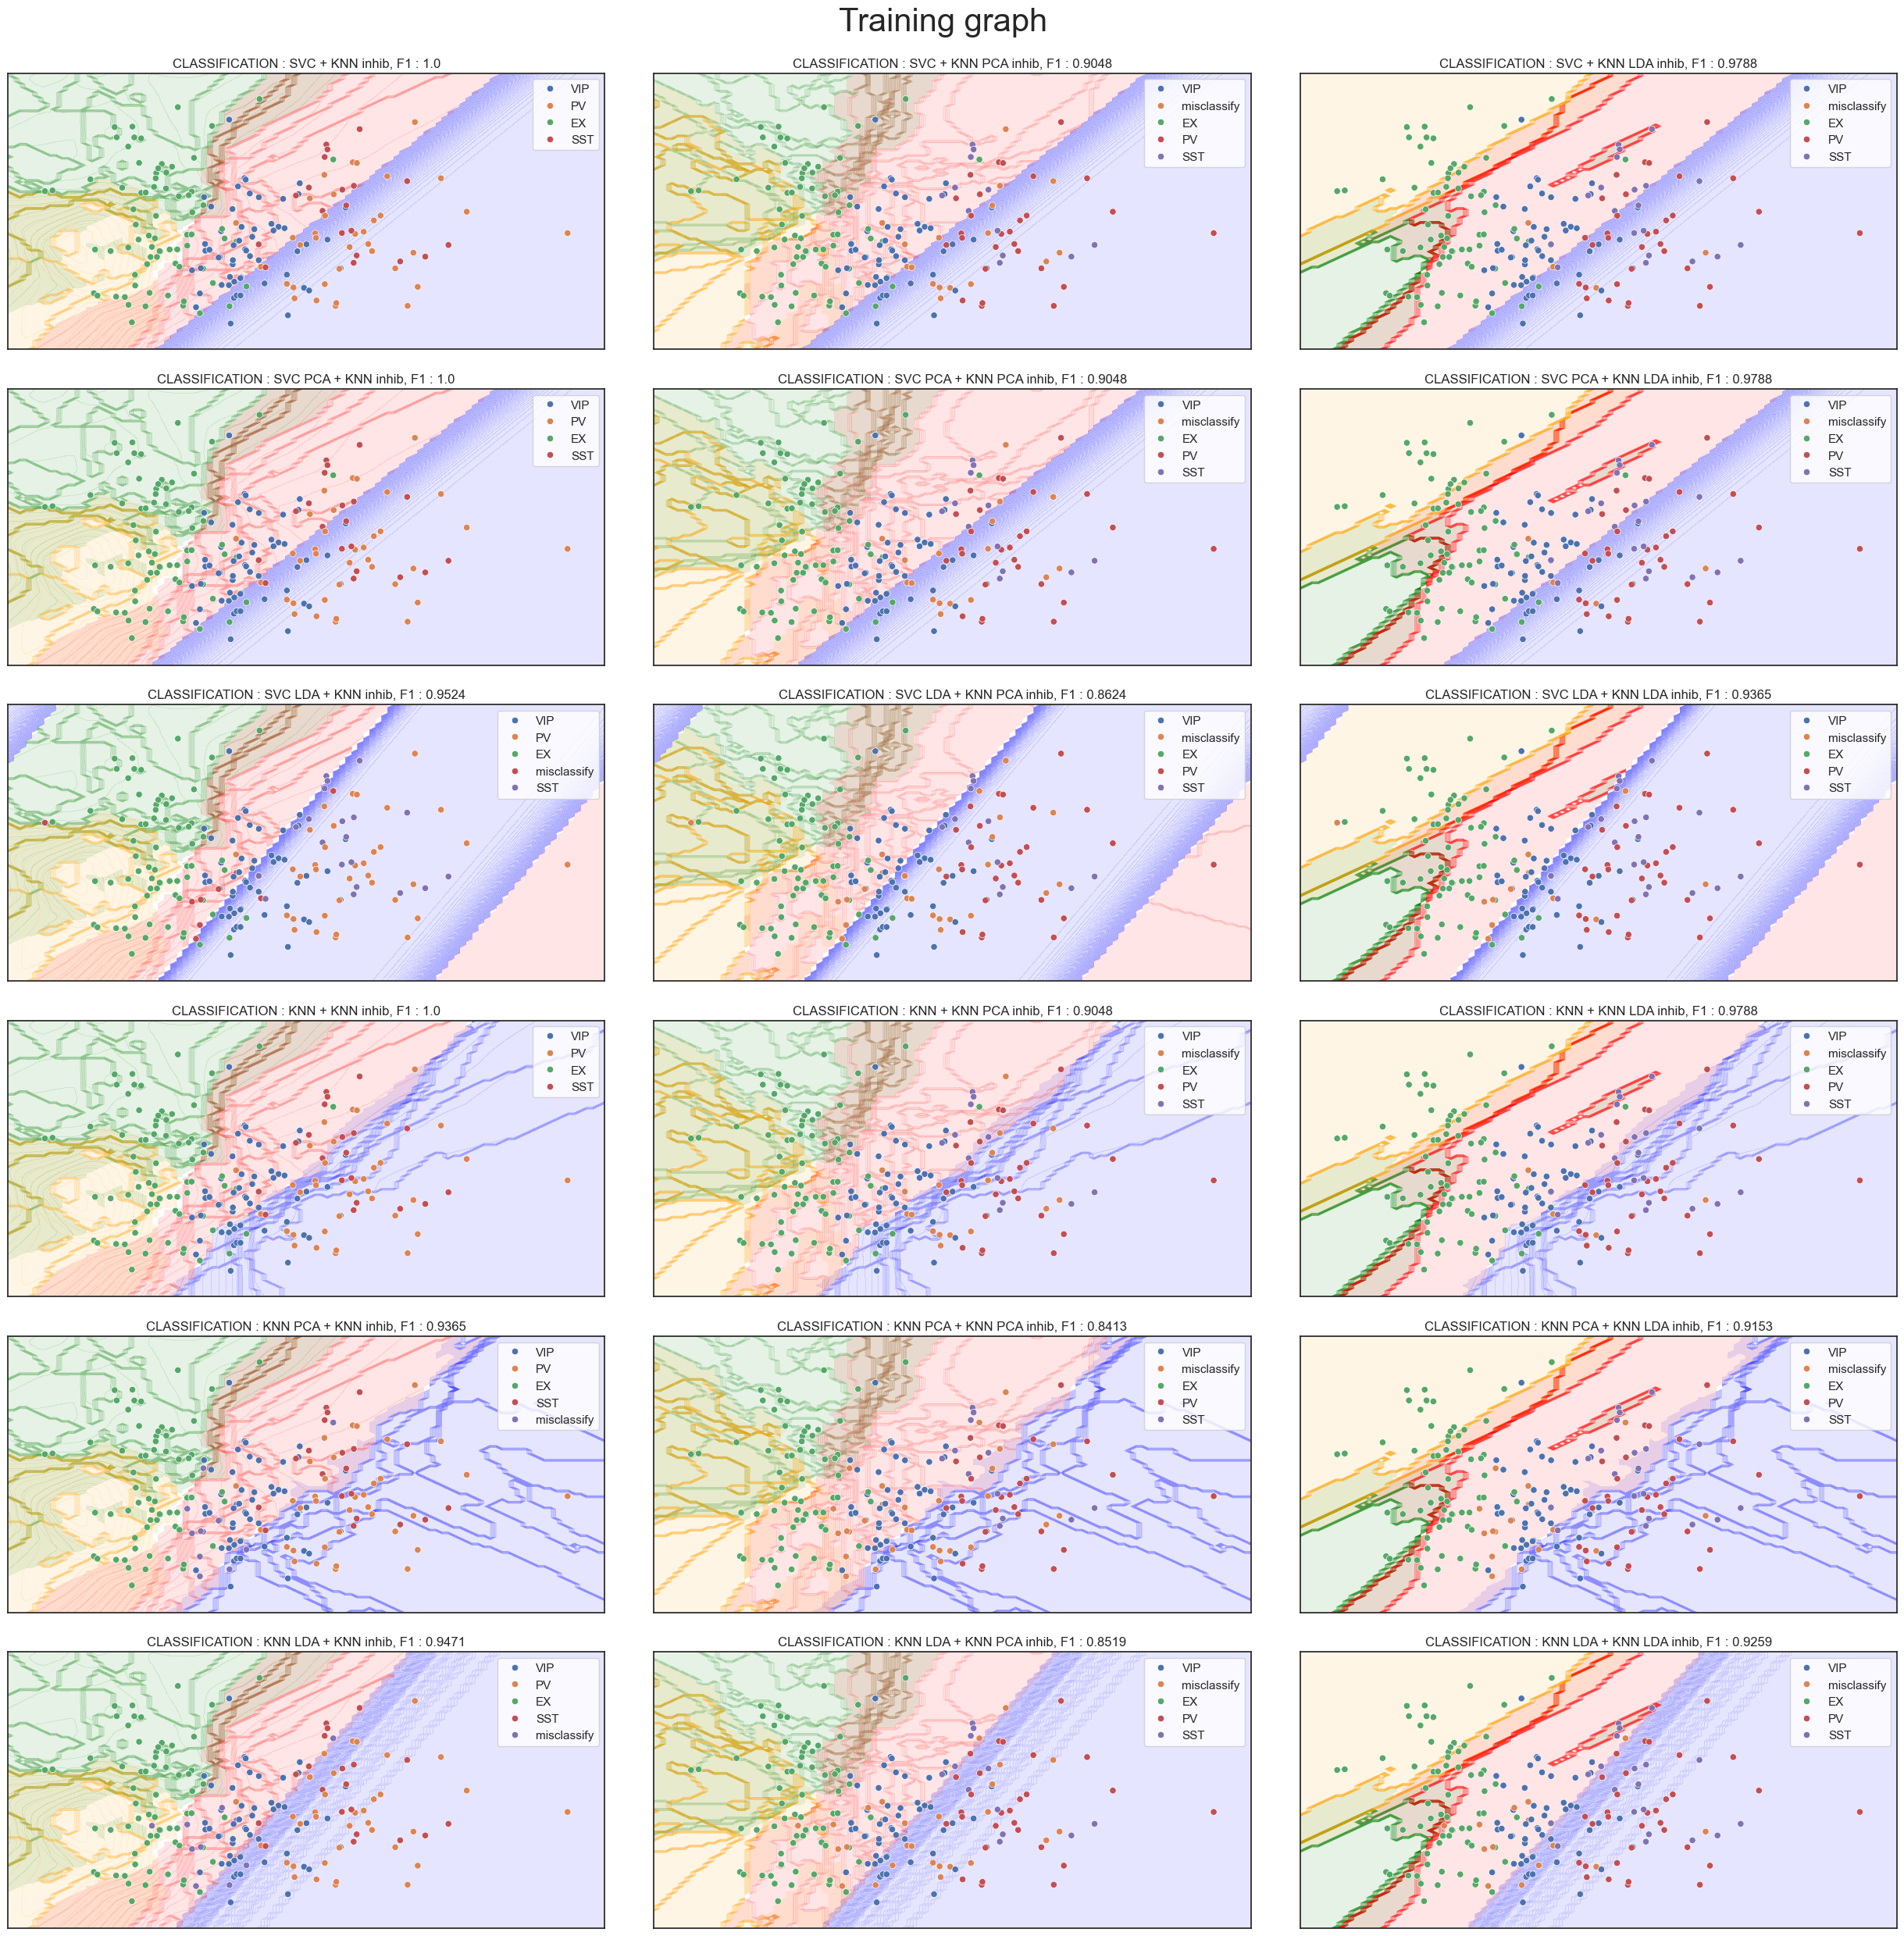

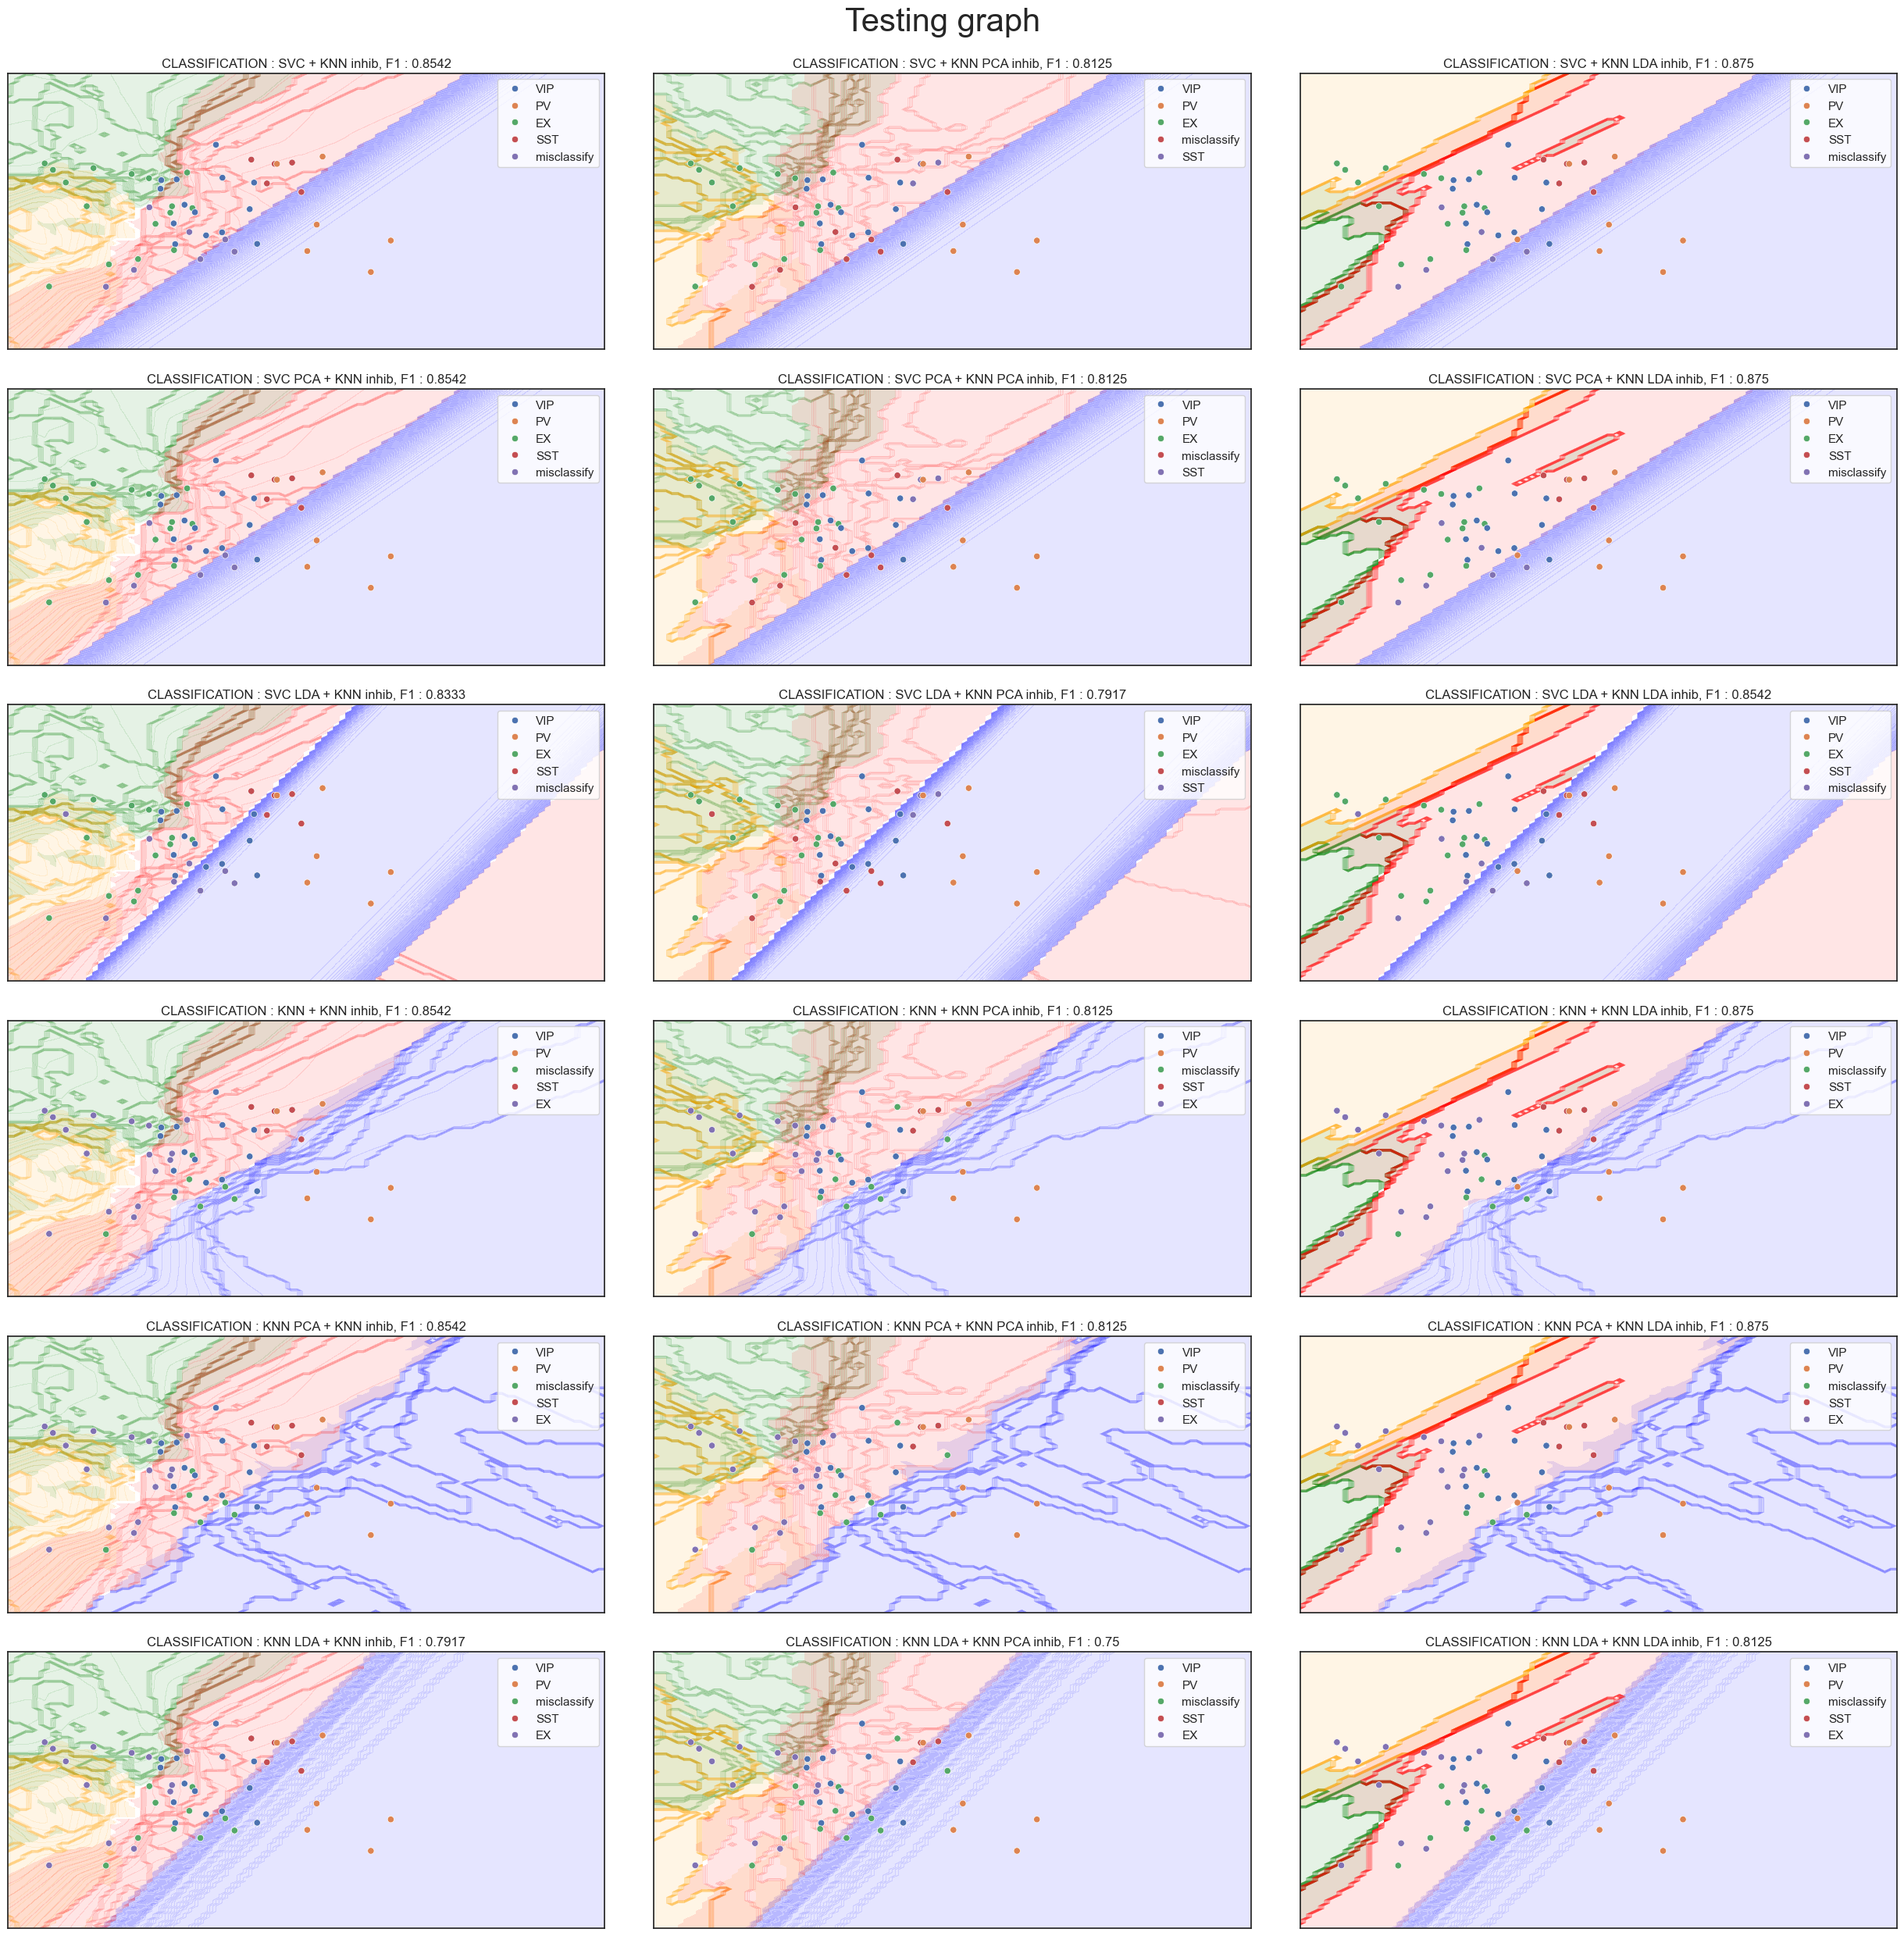

In [53]:
# STEP 2 : inhibitory KNN
# We will test every possible combination 
model_name1=  ['SVC', 'SVC PCA', 'SVC LDA','KNN', 'KNN PCA', 'KNN LDA']
model1s = [train_svc, train_svc_pca, train_svc_lda, train_knn, train_knn_pca, train_knn_lda] 
             
model_name2 = ['KNN inhib', 'KNN PCA inhib', 'KNN LDA inhib']
model2s = [train_knn_inhib, train_knn_pca_inhib, train_knn_lda_inhib]
data_trans = ['no', 'pca', 'lda']

for k, mode in enumerate(['Train', 'Test']) :
  
  fig, axs = plt.subplots(len(model1s),len(model2s), figsize = (25, 25))
  fig.suptitle(f"{mode}ing graph", y =1.002, size=30)
  fig.tight_layout()

  if mode == 'Train':
    X1 = [x_train_all, x_pca_bin, x_lda_bin]
    y_true = y_train_all
    xx,yy=xx_all, yy_all

  if mode == 'Test':
    X1 = [x_test_all, x_test_pca_bin, x_test_lda_bin]
    y_true = y_test_all
    xx,yy=xx_test, yy_test 
    
 
  inverse_pca_2D=pca_2D.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
  
  map_=[inverse_pca_2D,pca_all.transform(inverse_pca_2D)[:,:x_pca_bin.shape[1]], lda_bin.transform(inverse_pca_2D)]

  for i, model1 in enumerate(model1s) :
      for j, model2 in enumerate(model2s):
        
        Z = model1.predict_proba(map_[i%3])[:,1]
        Z = Z.reshape(xx.shape)
        map_ids=Z>=0.5
        y_pred=model1.predict(X1[i%3])

        id_pred_inhib=np.where(y_pred==1)[0]
        # choose the right transformation 
        if data_trans[j] == 'no' : X2 = X1[0]; map2=map_[0]
        if data_trans[j] == 'pca' : X2=pca_inhib.transform(np.delete(X1[0], low_feat_inhib, axis=1))[:,:23];map2=pca_inhib.transform(np.delete(map_[0], low_feat_inhib, axis=1))[:,:23]
        if data_trans[j] =='lda' : X2= lda_inhibitory.transform(X1[0]);map2=lda_inhibitory.transform(map_[0])

        y_pred[id_pred_inhib]=model2.predict(X2[id_pred_inhib])
        Z2=model2.predict_proba(map2[ map_ids.ravel()])
    


        
        y_labels = y_pred
        y_labels[y_pred != y_true] = 1

        y_maps = {0: 'EX', 10: 'PV', 11: 'SST', 12: 'VIP',1:'misclassify'}
        y_labels_ =[y_maps[i] for i in y_labels]

        df_result = pd.DataFrame(pca_raw[k])
        df_result['Labels'] = y_labels_

        final_score = f1_score(y_true,y_pred, average='micro')

        
        # Step 5: Combine the results from both classifiers
        proba_combined = np.zeros((xx.shape[0], xx.shape[1], 4))  # 4 classes (0, 10, 11, 12)
        proba_combined[:, :, 0] = 1 - Z  # Class 0 (non-inhibitory)
        Z2_reshaped = np.zeros((xx.shape[0], xx.shape[1], 3))  # 3 classes: 10, 11, 12
        Z2_reshaped[map_ids, :] = Z2  # Assign Z2 to the corresponding map_ids locations

        # Now assign the reshaped Z2 values to the last 3 columns of proba_combined
        proba_combined[:, :, 1:] = Z2_reshaped  
        # Step 6: Plot probability contours for each class
        
        # Define custom colors for each class (0, 10, 11, 12)
        class_colors = ['blue', 'green', 'orange', 'red']
        for class_idx in range(4):  # Iterate over 4 classes (0, 10, 11, 12)
            # Plot contours for the current class with the assigned color and transparency
            threhold=0.4 if class_idx==0 else 0.33
            z=proba_combined[:, :, class_idx]
            z=np.where(threhold>=z, np.nan, z)
                    # Adjust contour levels dynamically based on the range of probabilities for this class
            min_prob = np.nanmin(z)
            max_prob = np.nanmax(z)
            
            # Define the levels for the contour plot
            levels = np.linspace(min_prob, max_prob, 60)  # 20 contour levels
            axs[i][j].contourf(xx, yy,z, levels=levels, alpha=0.1, colors=class_colors[class_idx])
            #axs[i][j].contour(xx, yy, proba_combined[:, :, class_idx], levels=[0.5], colors=class_colors[class_idx], linewidths=2)
      

        sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i][j])
        axs[i][j].legend()

        axs[i][j].set_title(f"CLASSIFICATION : {model_name1[i]} + {model_name2[j]}, F1 : {round(final_score,4)}")
  
        # Remove ticks 
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])  
        axs[i][j].set(xlabel=None)
        axs[i][j].set(ylabel=None)



Threshold

In [54]:
from sklearn.metrics import precision_recall_curve

best1 = train_svc_pca
best2 = train_knn_lda_inhib


In [55]:
x_thresh_bin=pca_all.transform(np.concatenate((x_train_all,x_test_all)))[:,:x_pca_bin.shape[1]]
y_thresh=np.concatenate((y_train_bin,y_test_bin))
class_labels_bin=[0,1]
n_classes_bin = len(class_labels_bin)
best_thresholds_bin=[]
# Create a mapping from class labels to continuous indices
class_to_idx = {label: idx for idx, label in enumerate(class_labels_bin)}

# Initialize StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate over each fold
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x_thresh_bin, y_thresh)):  # Groups are not used here
     X_train_tresh, X_val_tresh = x_thresh_bin[train_idx], x_thresh_bin[val_idx]
     y_train_tresh, y_val_tresh = y_thresh[train_idx], y_thresh[val_idx]

# Clone the model to ensure a fresh fit each time
     model_clone = clone(best1)
     model_clone.fit(X_train_tresh, y_train_tresh)

# Get predicted probabilities
     probas = model_clone.predict_proba(X_val_tresh)[:,1]
     
     precision, recall, thresholds = precision_recall_curve(y_val_tresh, probas)
     f1_scores = np.divide(2 * (precision * recall), (precision + recall), where=(precision + recall)!=0, out=np.zeros_like(precision))   # Calculate F1 scores
     best_threshold = thresholds[np.argmax(f1_scores)]  # Select threshold that maximizes F1 score
     best_thresholds_bin.append(best_threshold)

# Average the thresholds across all folds
best_thresholds_bin = np.mean(best_thresholds_bin)  # Use nanmean to ignore NaNs
print("Best thresholds per class (averaged across folds):", best_thresholds_bin)





Best thresholds per class (averaged across folds): 0.5425074749659534


In [56]:
x_thresh_inhib=np.concatenate((x_train_all,x_test_all))
y_thresh_inhib=np.concatenate((y_train_all,y_test_all))


best_thresholds_inhib=[]
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x_thresh_inhib,y_thresh_inhib)):  # Groups are not used here
     X_train_tresh, X_val_tresh = x_thresh_inhib[train_idx], x_thresh_inhib[val_idx]
     y_train_tresh, y_val_tresh = y_thresh_inhib[train_idx], y_thresh_inhib[val_idx]
     y_train_tresh_bin=np.where(y_train_tresh==0,0,1)
     y_test_tresh_bin=np.where(y_val_tresh==0,0,1)
     id_bin=np.where(y_train_tresh!=0)[0]
     X_train_tresh_pca=pca_all.transform(X_train_tresh)[:,:x_pca_bin.shape[1]]
     x_val_tresh_pca=pca_all.transform(X_val_tresh)[:,:x_pca_bin.shape[1]]
# Clone the model to ensure a fresh fit each time
     model_clone = clone(best1)
     model_clone.fit(X_train_tresh_pca, y_train_tresh_bin)

# Get predicted probabilities
     probas = model_clone.predict_proba(x_val_tresh_pca)[:,1]
     y_pred=np.where(probas>=best_thresholds_bin,1,0)   
     id_inhib=np.where(y_pred==1)[0]
     
     X_train_tresh_lda=lda_inhibitory.transform(X_train_tresh)
     x_val_tresh_lda=lda_inhibitory.transform(X_val_tresh)
     model2_clone=clone(best2)
     #print(y_train_tresh[id_bin])
     model2_clone.fit(X_train_tresh_lda[id_bin], y_train_tresh[id_bin])
     
     probas2 = model2_clone.predict_proba(x_val_tresh_lda[id_inhib])
     #print(y_val_tresh[id_inhib])
     best_threshold_inhib=[]
     for i,label in enumerate([10,11,12]):
          precision, recall, thresholds = precision_recall_curve(y_val_tresh[id_inhib]==label, probas2[:,i])
          f1_scores = np.divide(2 * (precision * recall), (precision + recall), where=(precision + recall)!=0, out=np.zeros_like(precision))   # Calculate F1 scores
          best_threshold = thresholds[np.argmax(f1_scores)]  # Select threshold that maximizes F1 score
          best_threshold_inhib.append(best_threshold )
     best_thresholds_inhib.append(best_threshold_inhib)
     
     
best_thresholds_inhib = np.mean(best_thresholds_inhib,axis=0)  # Use nanmean to ignore NaNs
print("Best thresholds per class (averaged across folds):", best_thresholds_inhib)


Best thresholds per class (averaged across folds): [1.         0.66666667 0.73333333]


In [57]:
def predict_class(probabilities, thresholds):
    predicted_labels = []
    
    for sample in probabilities:
        # Initialize predicted label as None for each sample
        predicted_label = None
        
        # Check each class
        for i, (prob, threshold) in enumerate(zip(sample, thresholds)):
            if prob > threshold:
                predicted_label = i +10 # Assign class index if condition is met
        
        # If no class exceeds the threshold, choose the class with the highest probability
        if predicted_label is None:
            predicted_label =np.argmax(probabilities)+10
        predicted_labels.append(predicted_label)
    
    return predicted_labels

In [58]:

dataset_best1 = [x_pca_bin, x_test_pca_bin]
raw_dataset = [x_train_all, x_test_all]
y_true=[y_train_all, y_test_all]

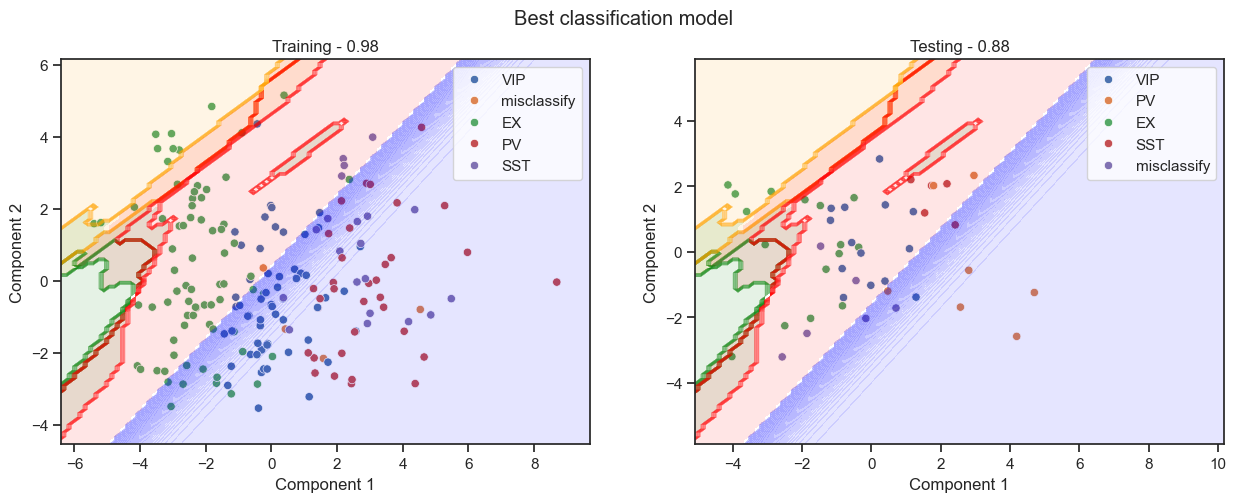

In [59]:
# plot the best combi # TODO : select the best model above



best_trans = 'lda'

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Best classification model')

for i, mode in enumerate(['Train', 'Test']):
    if mode == 'Train':
        xx, yy = xx_all, yy_all

    if mode == 'Test':
        xx, yy = xx_test, yy_test

    inverse_pca_2D = pca_2D.inverse_transform(np.c_[xx.ravel(), yy.ravel()])

    # Make sure map_ is defined and the correct dataset is used
    Z = best1.predict_proba(map_[1])[:, 1]
    Z = Z.reshape(xx.shape)
    map_ids = Z >= best_thresholds_bin

    y_pred = np.where(best1.predict_proba(dataset_best1[i])[:, 1] >= best_thresholds_bin, 1, 0)
    id_pred_inhib = np.where(y_pred == 1)[0]

    if 'lda' in best_trans:
        X2 = lda_inhibitory.transform(raw_dataset[i])

    map2 = lda_inhibitory.transform(map_[0])

    # Make predictions using the second classifier (best2)
    y_pred[id_pred_inhib] = best2.predict(X2[id_pred_inhib])
    Z2 = best2.predict_proba(map2[map_ids.ravel()])

    y_labels = y_pred
    y_labels[y_pred != y_true[i]] = 1  # Misclassified labels set to 1

    # Calculate score
    final_score = f1_score(y_true[i], y_pred, average='micro')

    # Prepare for plotting
    y_maps = {0: 'EX', 10: 'PV', 11: 'SST', 12: 'VIP', 1: 'misclassify'}
    y_labels_ = [y_maps[i] for i in y_labels]

    df_result = pd.DataFrame(pca_raw[i])
    df_result['Labels'] = y_labels_

    sns.scatterplot(data=df_result, x=0, y=1, hue='Labels', ax=ax[i])

    # Step 5: Combine the results from both classifiers
    proba_combined = np.zeros((xx.shape[0], xx.shape[1], 4))  # 4 classes (0, 10, 11, 12)
    proba_combined[:, :, 0] = 1 - Z  # Class 0 (non-inhibitory)
    Z2_reshaped = np.zeros((xx.shape[0], xx.shape[1], 3))  # 3 classes: 10, 11, 12
    Z2_reshaped[map_ids, :] = Z2  # Assign Z2 to the corresponding map_ids locations

    # Now assign the reshaped Z2 values to the last 3 columns of proba_combined
    proba_combined[:, :, 1:] = Z2_reshaped

    # Step 6: Plot probability contours for each class
    class_colors = ['blue', 'green', 'orange', 'red']
    for class_idx in range(4):  # Iterate over the first two classes (0, 10)
        threhold = 0.4 if class_idx == 0 else 0.33
        z = proba_combined[:, :, class_idx]
        z = np.where(threhold >= z, np.nan, z)

        # Adjust contour levels dynamically based on the range of probabilities for this class
        min_prob = np.nanmin(z)
        max_prob = np.nanmax(z)

        # Define the levels for the contour plot
        levels = np.linspace(min_prob, max_prob, 60)  # 60 contour levels
        ax[i].contourf(xx, yy, z, levels=levels, alpha=0.1, colors=class_colors[class_idx])

    ax[i].legend()
    ax[i].set_title(f"{mode}ing - {round(final_score, 2)}")

    # Remove ticks
    ax[i].set(xlabel='Component 1', ylabel='Component 2')

plt.show()

0.9788359788359788

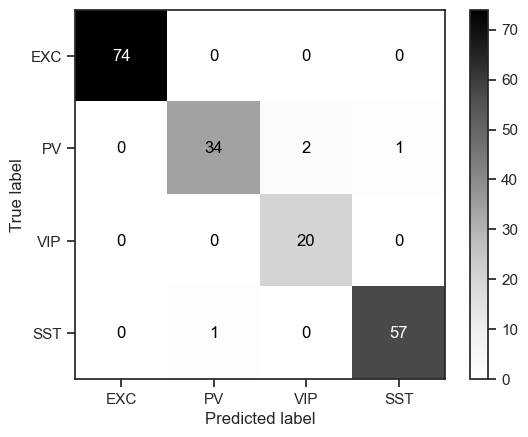

In [60]:
y_pred=train_svc_pca.predict(x_pca_bin)
id_pred=np.where(y_pred==1)[0]

# Choose the right transformation 
X2=lda_inhibitory.transform(x_train_all)
y_pred[id_pred]=train_knn_lda_inhib.predict(X2[id_pred])

ConfusionMatrixDisplay(confusion_matrix(y_train_all,y_pred), display_labels=cell_class_order).plot(cmap=plt.cm.Greys)
plt.xticks()
f1_score(y_train_all,y_pred, average='micro')

0.875


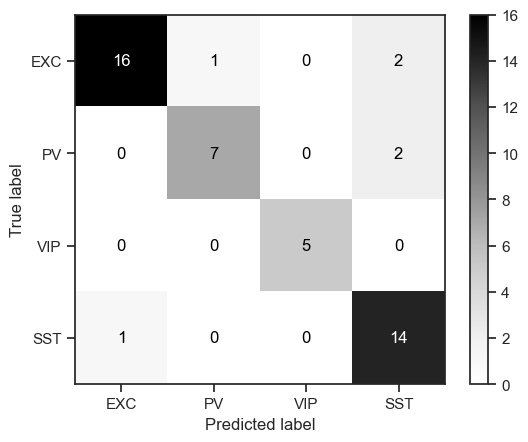

In [61]:
##### Combined testing performance #####
best1 = train_svc_pca
dataset_best1 = x_test_pca_bin

best2 = train_knn_lda_inhib
dataset_best2 = lda_inhibitory.transform(x_test_all)
#dataset_best2 = x_test_inhib
#dataset_best2=pca_inhib.transform(np.delete(x_test_all, low_feat_inhib, axis=1))[:,:x_pca_inhib.shape[1]]

y_pred = best1.predict(dataset_best1)
id_pred_inhib=np.where(y_pred==1)[0]
y_pred[id_pred_inhib]=best2.predict(dataset_best2[id_pred_inhib])

ConfusionMatrixDisplay(confusion_matrix(y_test_all,y_pred), display_labels=cell_class_order).plot(cmap=plt.cm.Greys)
print(f1_score(y_test_all,y_pred, average='micro'))

df_scores['TEST'] = f1_score(y_test_all,y_pred, average='micro')

In [62]:
df_scores = pd.DataFrame(scores, index=[0], columns=scores.keys())

df_scores.to_csv('scores.csv')

In [63]:
df_scores

Baseline train  Baseline test  train_svc  train_svc_pca  train_svc_lda  \
0         0.89418         0.8125        1.0            1.0       0.960352   

   train_knn  train_knn_pca  train_knn_lda  train_knn_inhib  \
0        1.0       0.948718       0.957265              1.0   

   train_knn_pca_inhib  train_knn_lda_inhib  test_svc  test_svc_pca  \
0             0.843478             0.965217  0.933333      0.933333   

   test_svc_lda  test_knn  test_knn_pca  test_knn_lda  test_knn_inhib  \
0      0.918033  0.933333      0.933333      0.888889        0.896552   

   test_knn_pca_inhib  test_knn_lda_inhib  
0            0.827586            0.931034

### Which Componant matter

/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/2643284059.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axs[0].get_xticklabels(), rotation = 90)


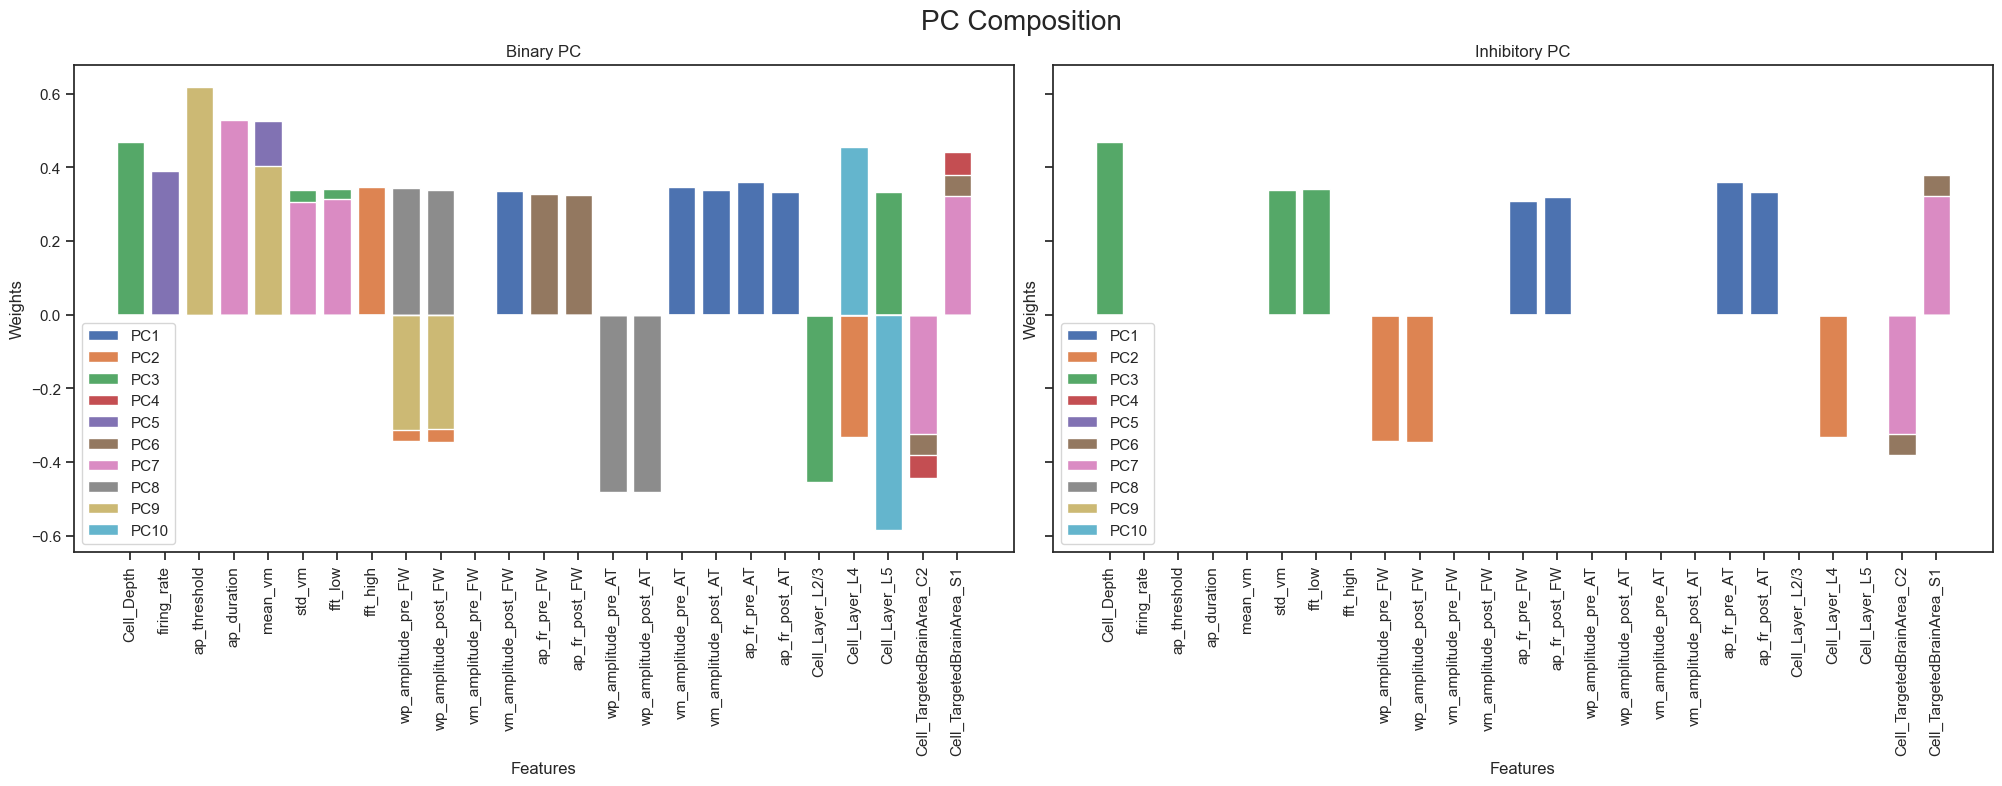

In [64]:
# PCA componants analysis
Compo_show = 10
thr = 0.3

# fig
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig.suptitle('PC Composition', fontsize=20)
fig.tight_layout()

# STEP 1 : binary classification
axs[0].set_title('Binary PC')
PCA_compo_bin = pca_all.components_[:Compo_show].T
PCA_compo_bin = np.where(abs(PCA_compo_bin) > thr, PCA_compo_bin, 0)

df_PCA_compo_bin = pd.DataFrame(PCA_compo_bin,columns=[f"PC{i+1}" for i in range(len(X.columns[:Compo_show]))],index=X.columns).reset_index()

for col in df_PCA_compo_bin.columns[1:] :
    axs[0].bar(x=df_PCA_compo_bin['index'], height = df_PCA_compo_bin[col], align='center')


# STEP 2 : inhibitory classification
axs[1].set_title('Inhibitory PC')

PCA_compo_inhib = pca_inhib.components_[:Compo_show].T
PCA_compo_inhib = np.where(abs(PCA_compo_inhib) > thr, PCA_compo_bin, 0)
df_PCA_compo_inhib = pd.DataFrame(PCA_compo_inhib,columns=[f"PC{i+1}" for i in range(len(X.columns[:Compo_show]))],index=X.columns).reset_index()

for col in df_PCA_compo_bin.columns[1:] :
    axs[1].bar(x=df_PCA_compo_inhib['index'], height = df_PCA_compo_inhib[col], align='center')

# Formate
for ax in axs :
    ax.set_xticklabels(axs[0].get_xticklabels(), rotation = 90)
    ax.legend(df_PCA_compo_bin.columns[1:])
    ax.set_ylabel('Weights')   
    ax.set_xlabel("Features")
plt.show()

In [65]:
# PCA bin principal componant PC1 capture mostly AP frequency and Vm amplitude 
# --> it's known that inhibitry vs exitatory cell have distinguishable AP frequencies
# but here both exp are equally taken showing the behavor of each cell type is context dependant and specific for the 2 class
# The Vm help as well but coudl not be ≠ in 2 experiments

print(df_PCA_compo_bin[df_PCA_compo_bin.PC1 != 0]['index'])

11    vm_amplitude_post_FW
12            ap_fr_pre_FW
13           ap_fr_post_FW
16     vm_amplitude_pre_AT
17    vm_amplitude_post_AT
18            ap_fr_pre_AT
19           ap_fr_post_AT
Name: index, dtype: object


/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/3135563207.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/3135563207.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


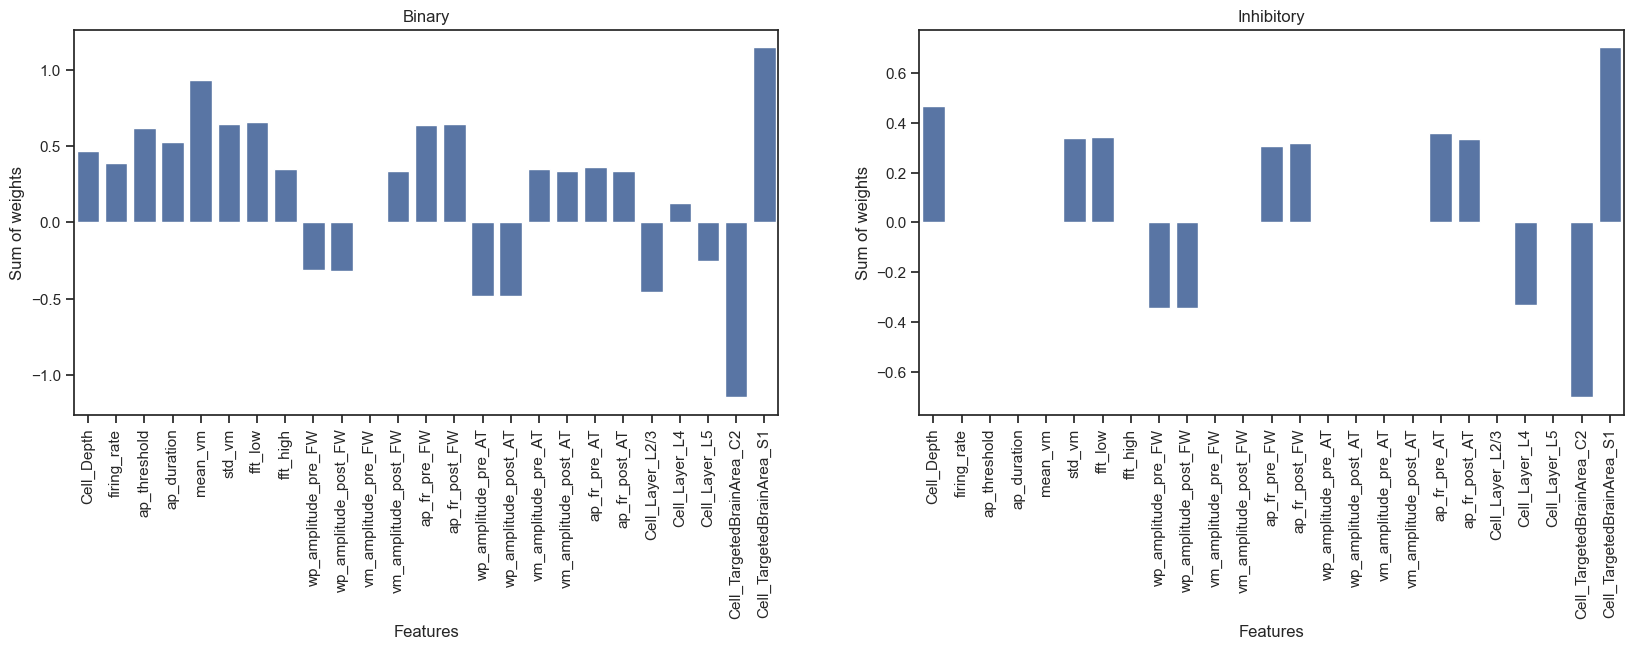

In [66]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
for ax, df in zip(axs, [df_PCA_compo_bin, df_PCA_compo_inhib]) :

    sum_ = df['PC1']
    for col in df.columns[2:]: 
        sum_ += df[col]

        df['sum'] = sum_ 

    sns.barplot(data = df, x='index', y='sum', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_ylabel('Sum of weights')   
    ax.set_xlabel("Features")
    
axs[0].set_title("Binary")
axs[1].set_title("Inhibitory")
plt.show()

/var/folders/rr/sx7rgrrj3p12hz70crvxqcjc0000gn/T/ipykernel_15316/1558318833.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90)


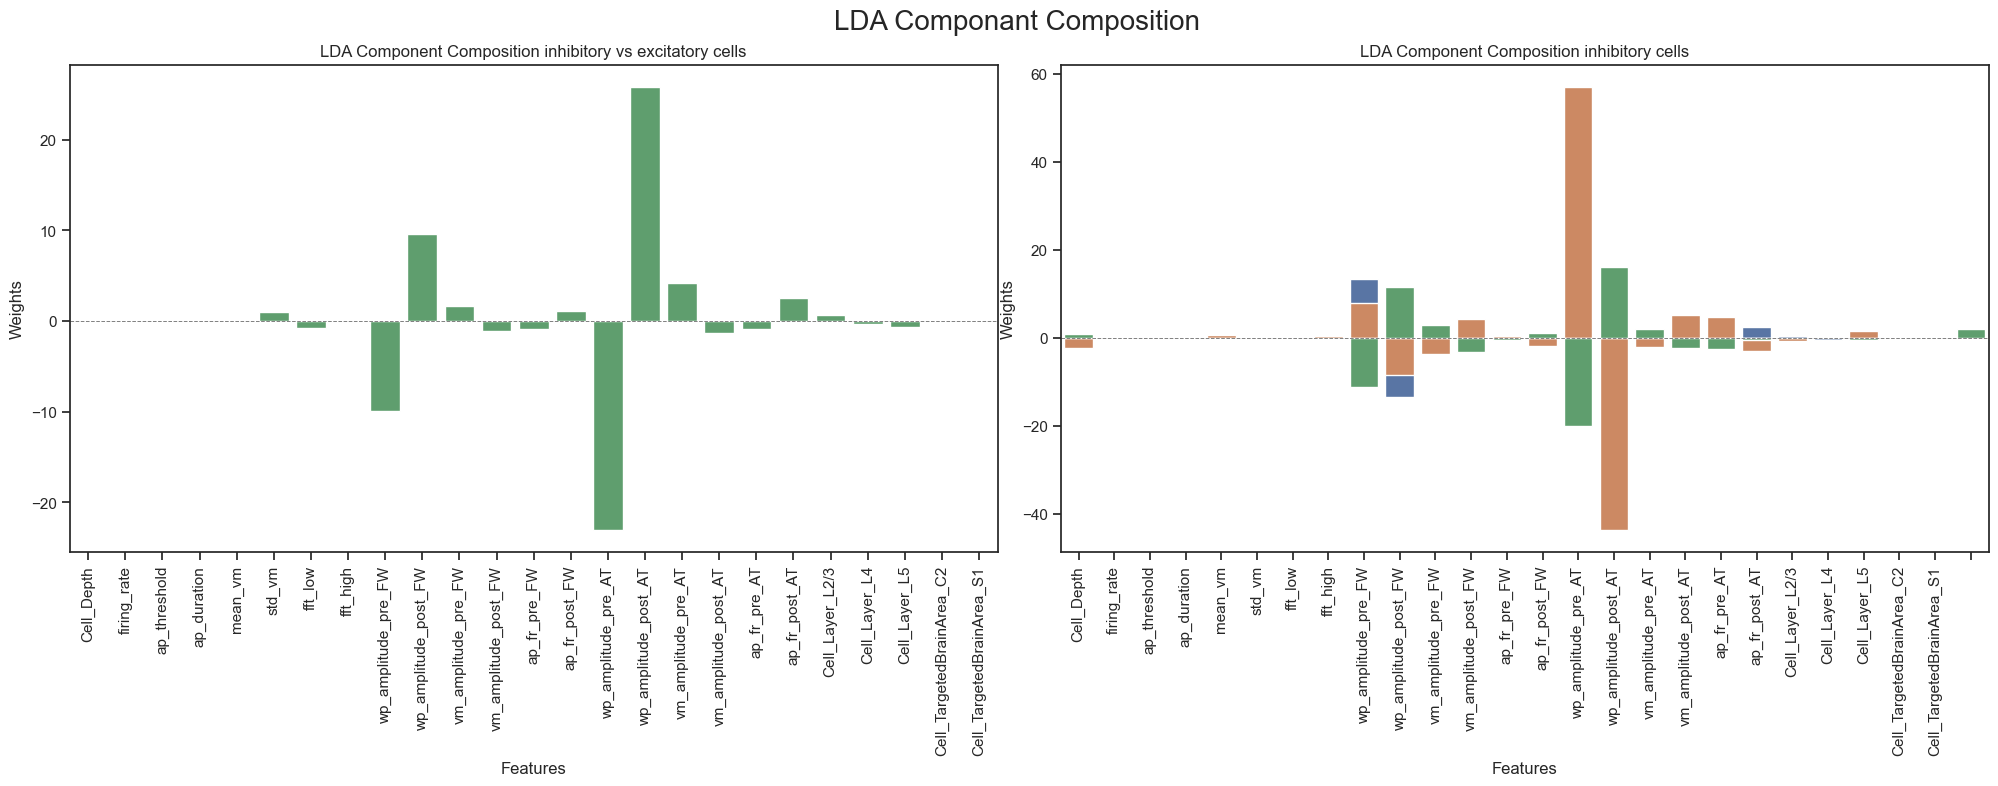

In [67]:
# LDA componants analysis
thr = 0.3
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('LDA Componant Composition', fontsize=20)
fig.tight_layout()

# STEP 1 : binary classification
LDA_compo_bin = lda_bin.coef_
LDA_compo_bin = np.where(abs(LDA_compo_bin) > thr, LDA_compo_bin, 0)
df_LDA_compo_bin = pd.DataFrame(LDA_compo_bin, columns = X.columns)

sns.barplot(data=df_LDA_compo_bin, ax=axs[0], color='g')
axs[0].set_title("LDA Component Composition inhibitory vs excitatory cells")


# STEP 2 : inhibitory classification
LDA_compo_inhib = lda_inhibitory.coef_[:Compo_show].T
LDA_compo_inhib = np.where(abs(LDA_compo_inhib) > thr, LDA_compo_inhib, 0)
df_LDA_compo_inhib = pd.DataFrame(LDA_compo_inhib.T, columns = X.columns)
df_LDA_compo_inhib['cluster'] = df_LDA_compo_inhib.index

sns.barplot(data=df_LDA_compo_inhib.iloc[0, :], ax=axs[1])
sns.barplot(data=df_LDA_compo_inhib.iloc[1, :], ax=axs[1])
sns.barplot(data=df_LDA_compo_inhib.iloc[2, :], ax=axs[1])

axs[1].set_title("LDA Component Composition inhibitory cells")

# Formate
for ax in axs :
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.set_xlabel("Features")
    ax.set_ylabel("Weights")
    ax.set_xticklabels(X.columns, rotation=90)

plt.show()

In [209]:
# BINARY : For LDA compaer to PCA the main features are "wp_Amplitude_pre_FW", "wp_Amplitude_post_FW", "wp_Amplitude_pre_AT", "wp_Amplitude_pre_AT"
# --> showing the specificity of each cell type for each reaction 

# INHIBITORY : 
# in between inhibitory cell what matter the most seems to be "wp_Amplitude_pre_AT", "wp_Amplitude_pre_AT" 
# --> they are a very ≠ behavior during the AT task but not so much during the FW ? 